In [2]:
from __future__ import division
import os
from collections import OrderedDict,Counter
import pandas as pd
import numpy as np
import vcf
from operator import itemgetter
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.ticker as mtick
%matplotlib inline
import math
from scipy.stats import ks_2samp
from scipy.stats import anderson_ksamp
from os import path as op
from os import listdir as ls
from scipy.stats import spearmanr
import skbio
from scipy.stats import pearsonr

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: license expired

    the package numpy 1.10.2 was published on 2015-12-14,
    however the mkl license expiration date is 2015-05-28.
    You may be able to run earlier versions of numpy using your
    current license.  A new license can be purchased at: http://continuum.io
    To revert to an earlier set of conda packages, use:
    $ conda list --revisions
    ...
    $ conda install --revision <REVISION NUMBER>

    


# make SNPmat

In [43]:
#get the hierftrans for all SNPS, created above as infile for multilocus FST
#z12 file created in 06_pca.ipyn
filE = '/home/lindb/wbp/OutFLANK/imputed_z12_maf_swp_trans_z12.txt'
imp012 = pd.read_csv(filE,header=0,index_col=0,sep="\t")
imp012.head()

,NODE_1000013_length_91_cov_1.802198_37,NODE_1000031_length_98_cov_2.000000_30,NODE_1000037_length_93_cov_2.043011_33,NODE_1000042_length_93_cov_1.118280_100,NODE_1000053_length_94_cov_1.744681_25,NODE_1000061_length_47_cov_1.680851_49,NODE_1000118_length_95_cov_2.000000_24,NODE_1000128_length_98_cov_1.714286_53,NODE_1000180_length_98_cov_2.204082_17,NODE_1000188_length_67_cov_1.223881_65,...,NODE_999880_length_98_cov_1.683674_22,NODE_999886_length_96_cov_1.020833_38,NODE_999899_length_96_cov_1.000000_91,NODE_999927_length_95_cov_2.000000_55,NODE_999933_length_76_cov_1.236842_76,NODE_999938_length_98_cov_1.142857_98,NODE_999941_length_107_cov_1.196262_25,NODE_999958_length_91_cov_1.021978_17,NODE_999968_length_75_cov_1.680000_37,NODE_999969_length_92_cov_4.271739_37
009compiled,0,1,0,0,0,0,1,0,1,0,...,0,0,1,0,1,1,0,0,0,1
010compiled,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
011compiled,1,0,1,0,0,0,1,0,1,0,...,0,0,1,0,1,0,0,0,0,0
012compiled,0,0,0,1,0,0,1,0,1,0,...,0,1,2,0,1,0,0,0,1,1
013compiled,2,0,0,0,0,0,1,1,1,0,...,0,0,1,0,1,0,0,0,0,1


In [70]:
#get pop assignment for each samp
filE = '/home/lindb/wbp/sampsTOpop.txt'
stp = pd.read_csv(filE,header=0,index_col='sampID',sep="\t")
stp.head()

,pop,plot
sampID,,
028compiled,Dicks_Pass,3
024compiled,Dicks_Pass,2
020compiled,Dicks_Pass,2
025compiled,Dicks_Pass,2
023compiled,Dicks_Pass,2


In [71]:
merged = pd.merge(imp012,stp,left_index=True,right_index=True)
cols = ['pop'] + [col for col in merged.columns if 'NODE' in col]
merged = merged[cols]
merged.sort_index(inplace=True)
merged.head()

,pop,NODE_1000013_length_91_cov_1.802198_37,NODE_1000031_length_98_cov_2.000000_30,NODE_1000037_length_93_cov_2.043011_33,NODE_1000042_length_93_cov_1.118280_100,NODE_1000053_length_94_cov_1.744681_25,NODE_1000061_length_47_cov_1.680851_49,NODE_1000118_length_95_cov_2.000000_24,NODE_1000128_length_98_cov_1.714286_53,NODE_1000180_length_98_cov_2.204082_17,...,NODE_999880_length_98_cov_1.683674_22,NODE_999886_length_96_cov_1.020833_38,NODE_999899_length_96_cov_1.000000_91,NODE_999927_length_95_cov_2.000000_55,NODE_999933_length_76_cov_1.236842_76,NODE_999938_length_98_cov_1.142857_98,NODE_999941_length_107_cov_1.196262_25,NODE_999958_length_91_cov_1.021978_17,NODE_999968_length_75_cov_1.680000_37,NODE_999969_length_92_cov_4.271739_37
009compiled,Dicks_Pass,0,1,0,0,0,0,1,0,1,...,0,0,1,0,1,1,0,0,0,1
010compiled,Dicks_Pass,0,1,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
011compiled,Dicks_Pass,1,0,1,0,0,0,1,0,1,...,0,0,1,0,1,0,0,0,0,0
012compiled,Dicks_Pass,0,0,0,1,0,0,1,0,1,...,0,1,2,0,1,0,0,0,1,1
013compiled,Dicks_Pass,2,0,0,0,0,0,1,1,1,...,0,0,1,0,1,0,0,0,0,1


In [72]:
merged.shape

(244, 116232)

In [10]:
#make sure there aren't any weird data in the dataframe - like 'NAs' or 'np.nan'
for col in merged.columns:
    uni = np.unique(merged[col].tolist()).tolist()
    if (uni == [0,1]) or (uni == [0,1,2]) or (uni == [1,2]) or (uni == [0,2]):
        1+1
    else:
        print col, np.unique(merged[col].tolist()).tolist() #should only print the pop column

pop ['Dicks_Pass', 'Freel_Peak', 'Heavenly', 'Little_Round_Top', 'Mt_Rose_Ophir', 'Rifle_Peak', 'Snow_Valley_Peak', 'West_Shore_Peaks']


In [73]:
cols = [col for col in merged.columns if 'NODE' in col]
snpmat = merged[cols]
snpmat.head()

,NODE_1000013_length_91_cov_1.802198_37,NODE_1000031_length_98_cov_2.000000_30,NODE_1000037_length_93_cov_2.043011_33,NODE_1000042_length_93_cov_1.118280_100,NODE_1000053_length_94_cov_1.744681_25,NODE_1000061_length_47_cov_1.680851_49,NODE_1000118_length_95_cov_2.000000_24,NODE_1000128_length_98_cov_1.714286_53,NODE_1000180_length_98_cov_2.204082_17,NODE_1000188_length_67_cov_1.223881_65,...,NODE_999880_length_98_cov_1.683674_22,NODE_999886_length_96_cov_1.020833_38,NODE_999899_length_96_cov_1.000000_91,NODE_999927_length_95_cov_2.000000_55,NODE_999933_length_76_cov_1.236842_76,NODE_999938_length_98_cov_1.142857_98,NODE_999941_length_107_cov_1.196262_25,NODE_999958_length_91_cov_1.021978_17,NODE_999968_length_75_cov_1.680000_37,NODE_999969_length_92_cov_4.271739_37
009compiled,0,1,0,0,0,0,1,0,1,0,...,0,0,1,0,1,1,0,0,0,1
010compiled,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
011compiled,1,0,1,0,0,0,1,0,1,0,...,0,0,1,0,1,0,0,0,0,0
012compiled,0,0,0,1,0,0,1,0,1,0,...,0,1,2,0,1,0,0,0,1,1
013compiled,2,0,0,0,0,0,1,1,1,0,...,0,0,1,0,1,0,0,0,0,1


In [74]:
pops = pd.DataFrame(merged['pop'].tolist())
pops.head()

,0
0,Dicks_Pass
1,Dicks_Pass
2,Dicks_Pass
3,Dicks_Pass
4,Dicks_Pass


In [75]:
filE = '/home/lindb/wbp/OutFLANK/SNPmat_HEADERIDX.txt'
filE2 = '/home/lindb/wbp/OutFLANK/SNPmat_noHEADERIDX.txt'
print 'making 1st snpmat' #so I don't have to watch ls -lt
snpmat.to_csv(filE,header=True,index=True,sep="\t")
print 'making 2nd snpmat'
snpmat.to_csv(filE2,header=None,index=False,sep="\t")

popfile = '/home/lindb/wbp/OutFLANK/SNPmat_popNames.txt'
print 'making popfile'
pops.to_csv(popfile,header=False,index=False,sep="\t")

print 'making locfile'
locfile = '/home/lindb/wbp/OutFLANK/SNPmat_locusNames.txt'
cols = pd.DataFrame(snpmat.columns)
cols.to_csv(locfile,header=False,index=False,sep="\t")

making 1st snpmat
making 2nd snpmat
making popfile
making locfile


# Put into R

```R

library(OutFLANK)
library(data.table)

SNPmat = data.frame(fread('/home/lindb/wbp/OutFLANK/SNPmat_noHEADERIDX.txt',header=F,sep="\t"))

locusNames = read.csv('/home/lindb/wbp/OutFLANK/SNPmat_locusNames.txt',header=F,sep="\t")

popNames = read.csv('/home/lindb/wbp/OutFLANK/SNPmat_popNames.txt',header=F,sep="\t")

FstDataFrame = MakeDiploidFSTMat(SNPmat,locusNames,popNames)

out = OutFLANK(FstDataFrame = FstDataFrame,NumberOfSamples = 8)

df = out$results

outliers = df[which(df$OutlierFlag == 'TRUE'),]

loci = outliers$LocusName

write.table(df,'/home/lindb/wbp/OutFLANK/OutFLANK_results.txt',row.names=F,col.names=T,sep='\t')

write.table(loci,'/home/lindb/wbp/OutFLANK/OutFLANK_snps.txt',row.names=F,sep='\t')

print("DONE!")



```

In [6]:
snps = pd.read_csv('/home/lindb/wbp/OutFLANK/OutFLANK_snps.txt',header=0,sep="\t")
snps.head()

,x
0,NODE_1001690_length_90_cov_2.000000_37
1,NODE_1012475_length_88_cov_1.022727_43
2,NODE_1025193_length_75_cov_1.093333_47
3,NODE_1030410_length_81_cov_1.259259_40
4,NODE_1038234_length_92_cov_1.000000_53


In [510]:
res = pd.read_csv('/home/lindb/wbp/OutFLANK/OutFLANK_results.txt',header=0,sep='\t')
res.head()

,LocusName,He,FST,T1,T2,FSTNoCorr,T1NoCorr,T2NoCorr,meanAlleleFreq,indexOrder,GoodH,qvalues,pvalues,pvaluesRightTail,OutlierFlag
0,NODE_1000013_length_91_cov_1.802198_37,0.212569,-0.007865,-0.000837,0.106477,0.015786,0.001682,0.106519,0.879098,1,goodH,0.852193,0.852652,0.573674,False
1,NODE_1000031_length_98_cov_2.000000_30,0.257290,0.012300,0.001589,0.129188,0.032527,0.004204,0.129231,0.848361,2,goodH,0.724113,0.236842,0.118421,False
2,NODE_1000037_length_93_cov_2.043011_33,0.215668,-0.009567,-0.001032,0.107910,0.006997,0.000755,0.107939,0.877049,3,goodH,0.882429,0.163997,0.918002,False
3,NODE_1000042_length_93_cov_1.118280_100,0.078608,0.000216,0.000009,0.039383,0.016198,0.000638,0.039393,0.959016,4,lowH,0.848006,0.886690,0.556655,False
4,NODE_1000053_length_94_cov_1.744681_25,0.047971,-0.005962,-0.000143,0.024014,0.010505,0.000252,0.024021,0.975410,5,lowH,0.872100,0.408936,0.795532,False


In [517]:
fstnocorr = res['FSTNoCorr'].tolist()
min(fstnocorr)

7.7074811286143992e-06

In [159]:
len(snps.index)

110

# are outliers caused by effects from missing data?

In [182]:
#I want 'missing' because the 'imputed' will all have perc data (%missing data at a snp) == 1.0
#this file was made in 07_hierfstat_missing.ipynb
percdata = pd.read_csv('/home/lindb/wbp/hierfstat/missing/missing_hierarchical_Fstats.txt',header=0,index_col=0,sep="\t")
percdata = pd.DataFrame(percdata['perc data'])
percdata.head()

,perc data
NODE_1000013_length_91_cov_1.802198_37,0.692623
NODE_1000031_length_98_cov_2.000000_30,0.635246
NODE_1000037_length_93_cov_2.043011_33,0.688525
NODE_1000042_length_93_cov_1.118280_100,0.528689
NODE_1000053_length_94_cov_1.744681_25,0.831967


In [7]:
#use as index to merge
snps.index = [x for x in snps['x']]
snps.head()

,x
NODE_1001690_length_90_cov_2.000000_37,NODE_1001690_length_90_cov_2.000000_37
NODE_1012475_length_88_cov_1.022727_43,NODE_1012475_length_88_cov_1.022727_43
NODE_1025193_length_75_cov_1.093333_47,NODE_1025193_length_75_cov_1.093333_47
NODE_1030410_length_81_cov_1.259259_40,NODE_1030410_length_81_cov_1.259259_40
NODE_1038234_length_92_cov_1.000000_53,NODE_1038234_length_92_cov_1.000000_53


In [184]:
merged = pd.merge(snps,percdata,left_index=True,right_index=True)
merged.head()

,x,perc data
NODE_1001690_length_90_cov_2.000000_37,NODE_1001690_length_90_cov_2.000000_37,0.500000
NODE_1012475_length_88_cov_1.022727_43,NODE_1012475_length_88_cov_1.022727_43,0.647541
NODE_1025193_length_75_cov_1.093333_47,NODE_1025193_length_75_cov_1.093333_47,0.606557
NODE_1030410_length_81_cov_1.259259_40,NODE_1030410_length_81_cov_1.259259_40,0.520492
NODE_1038234_length_92_cov_1.000000_53,NODE_1038234_length_92_cov_1.000000_53,0.778689


In [45]:
len(merged.index)

110

(array([ 11.,  15.,  20.,  17.,  10.,  13.,  11.,   9.,   2.,   2.]),
 array([ 0.5       ,  0.53729508,  0.57459016,  0.61188525,  0.64918033,
         0.68647541,  0.72377049,  0.76106557,  0.79836066,  0.83565574,
         0.87295082]),
 <a list of 10 Patch objects>)

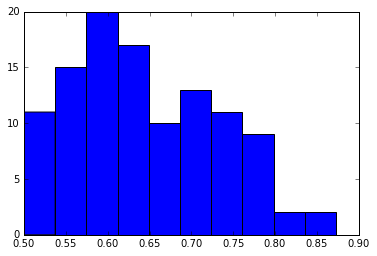

In [46]:
plt.hist(merged['perc data'])

(array([ 16415.,  16507.,  17156.,  16970.,  15864.,  13817.,  10528.,
          6669.,   2228.,     77.]),
 array([ 0.5       ,  0.54139344,  0.58278689,  0.62418033,  0.66557377,
         0.70696721,  0.74836066,  0.7897541 ,  0.83114754,  0.87254098,
         0.91393443]),
 <a list of 10 Patch objects>)

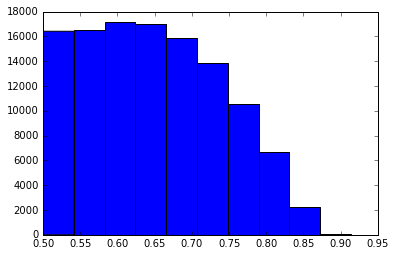

In [47]:
plt.hist(percdata['perc data'])

In [168]:
results = pd.read_csv('/home/lindb/wbp/OutFLANK/OutFLANK_results.txt',header=0,index_col='LocusName',sep="\t")
results.head()

,He,FST,T1,T2,FSTNoCorr,T1NoCorr,T2NoCorr,meanAlleleFreq,indexOrder,GoodH,qvalues,pvalues,pvaluesRightTail,OutlierFlag
LocusName,,,,,,,,,,,,,,
NODE_1000013_length_91_cov_1.802198_37,0.212569,-0.007865,-0.000837,0.106477,0.015786,0.001682,0.106519,0.879098,1,goodH,0.852193,0.852652,0.573674,False
NODE_1000031_length_98_cov_2.000000_30,0.257290,0.012300,0.001589,0.129188,0.032527,0.004204,0.129231,0.848361,2,goodH,0.724113,0.236842,0.118421,False
NODE_1000037_length_93_cov_2.043011_33,0.215668,-0.009567,-0.001032,0.107910,0.006997,0.000755,0.107939,0.877049,3,goodH,0.882429,0.163997,0.918002,False
NODE_1000042_length_93_cov_1.118280_100,0.078608,0.000216,0.000009,0.039383,0.016198,0.000638,0.039393,0.959016,4,lowH,0.848006,0.886690,0.556655,False
NODE_1000053_length_94_cov_1.744681_25,0.047971,-0.005962,-0.000143,0.024014,0.010505,0.000252,0.024021,0.975410,5,lowH,0.872100,0.408936,0.795532,False


In [169]:
np.unique(results['OutlierFlag'])

array([False,  True], dtype=bool)

In [170]:
trues = results[results[u'OutlierFlag'] == True]
len(trues.index)

110

In [171]:
trues.head()

,He,FST,T1,T2,FSTNoCorr,T1NoCorr,T2NoCorr,meanAlleleFreq,indexOrder,GoodH,qvalues,pvalues,pvaluesRightTail,OutlierFlag
LocusName,,,,,,,,,,,,,,
NODE_1001690_length_90_cov_2.000000_37,0.078608,0.079459,0.003163,0.039812,0.092968,0.003702,0.039821,0.959016,119,lowH,0.043708,7.923133e-05,3.961566e-05,True
NODE_1012475_length_88_cov_1.022727_43,0.398381,0.083805,0.016937,0.202103,0.105861,0.021403,0.202177,0.725410,1088,goodH,0.017647,1.207446e-05,6.037229e-06,True
NODE_1025193_length_75_cov_1.093333_47,0.464517,0.105168,0.024855,0.236338,0.126141,0.029822,0.236420,0.633197,2056,goodH,0.004376,5.906672e-07,2.953336e-07,True
NODE_1030410_length_81_cov_1.259259_40,0.346941,0.089409,0.015746,0.176111,0.109839,0.019350,0.176171,0.776639,2489,goodH,0.013175,6.714982e-06,3.357491e-06,True
NODE_1038234_length_92_cov_1.000000_53,0.265780,0.077760,0.010471,0.134655,0.096048,0.012937,0.134696,0.842213,3081,goodH,0.032068,5.071086e-05,2.535543e-05,True


In [185]:
merged2 = pd.merge(merged,pd.DataFrame(trues[['FST','FSTNoCorr']]),left_index=True,right_index=True)

In [186]:
merged2.head()

,x,perc data,FST,FSTNoCorr
NODE_1001690_length_90_cov_2.000000_37,NODE_1001690_length_90_cov_2.000000_37,0.500000,0.079459,0.092968
NODE_1012475_length_88_cov_1.022727_43,NODE_1012475_length_88_cov_1.022727_43,0.647541,0.083805,0.105861
NODE_1025193_length_75_cov_1.093333_47,NODE_1025193_length_75_cov_1.093333_47,0.606557,0.105168,0.126141
NODE_1030410_length_81_cov_1.259259_40,NODE_1030410_length_81_cov_1.259259_40,0.520492,0.089409,0.109839
NODE_1038234_length_92_cov_1.000000_53,NODE_1038234_length_92_cov_1.000000_53,0.778689,0.077760,0.096048


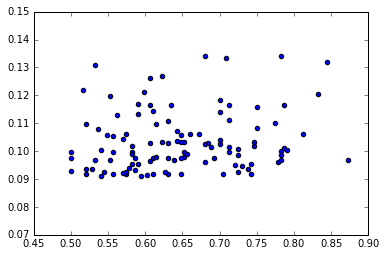

In [70]:
plt.scatter(merged2['perc data'],merged2['FSTNoCorr'])

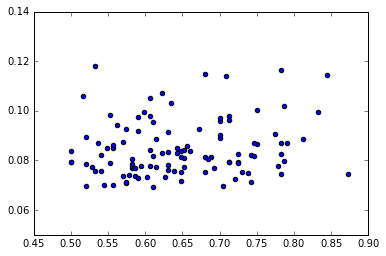

In [73]:
plt.scatter(merged2['perc data'],merged2['FST'])

In [75]:
merged2['FSTNoCorr'].describe()

count    110.000000
mean       0.103556
std        0.010733
min        0.090965
25%        0.095976
50%        0.100539
75%        0.108251
max        0.134076
Name: FSTNoCorr, dtype: float64

In [174]:
len(merged2.index)

110

In [188]:
#get multilocus f stats for the imputed outlier snps
#this file was made in 07_hierfstat_imputed.ipynb
impfstats = pd.read_csv('/home/lindb/wbp/hierfstat/imputed/imputed_hierarchical_Fstats.txt',header=0,index_col=0,sep="\t")
impfstats = impfstats.loc[:,[col for col in impfstats.columns if not 'perc' in col]]
impfstats.head()

,pop_total,plot_total,plot_pop
NODE_1000013_length_91_cov_1.802198_37,-0.002797,-0.018565,-0.015723
NODE_1000031_length_98_cov_2.000000_30,0.014700,0.007232,-0.007579
NODE_1000037_length_93_cov_2.043011_33,-0.008883,-0.011011,-0.002109
NODE_1000042_length_93_cov_1.118280_100,-0.008273,0.018138,0.026194
NODE_1000053_length_94_cov_1.744681_25,-0.020574,0.024885,0.044543


In [190]:
#get the important columns
allstats = pd.merge(impfstats,merged2.loc[:,[col for col in merged2.columns if not 'x' in col]],
                    left_index=True,right_index=True)
allstats.head()

,pop_total,plot_total,plot_pop,perc data,FST,FSTNoCorr
NODE_1001690_length_90_cov_2.000000_37,0.071807,0.095605,0.025640,0.500000,0.079459,0.092968
NODE_1012475_length_88_cov_1.022727_43,0.074489,0.103463,0.031307,0.647541,0.083805,0.105861
NODE_1025193_length_75_cov_1.093333_47,0.083945,0.149946,0.072049,0.606557,0.105168,0.126141
NODE_1030410_length_81_cov_1.259259_40,0.072266,0.125581,0.057468,0.520492,0.089409,0.109839
NODE_1038234_length_92_cov_1.000000_53,0.068178,0.097979,0.031981,0.778689,0.077760,0.096048


In [195]:
#rename so I don't have to search my script to find what they mean or where they come from
cols = ['pop_total_hierfstat', 'plot_total_hierfstat', 'plot_pop_hierfstat', 'perc missing genotypes', 'FST_outflank', 
        'FSTNoCorr_outflank']
allstats.columns = [col for col in cols]
allstats.head()

,pop_total_hierfstat,plot_total_hierfstat,plot_pop_hierfstat,perc missing genotypes,FST_outflank,FSTNoCorr_outflank
NODE_1001690_length_90_cov_2.000000_37,0.071807,0.095605,0.025640,0.500000,0.079459,0.092968
NODE_1012475_length_88_cov_1.022727_43,0.074489,0.103463,0.031307,0.647541,0.083805,0.105861
NODE_1025193_length_75_cov_1.093333_47,0.083945,0.149946,0.072049,0.606557,0.105168,0.126141
NODE_1030410_length_81_cov_1.259259_40,0.072266,0.125581,0.057468,0.520492,0.089409,0.109839
NODE_1038234_length_92_cov_1.000000_53,0.068178,0.097979,0.031981,0.778689,0.077760,0.096048


In [196]:
#write to file
filE = '/home/lindb/wbp/OutFLANK/hierarchical_Fstats_outflankoutliers.txt'
allstats.to_csv(filE,header=True,index=True,sep='\t')

In [197]:
allstats.head()

,pop_total_hierfstat,plot_total_hierfstat,plot_pop_hierfstat,perc missing genotypes,FST_outflank,FSTNoCorr_outflank
NODE_1001690_length_90_cov_2.000000_37,0.071807,0.095605,0.025640,0.500000,0.079459,0.092968
NODE_1012475_length_88_cov_1.022727_43,0.074489,0.103463,0.031307,0.647541,0.083805,0.105861
NODE_1025193_length_75_cov_1.093333_47,0.083945,0.149946,0.072049,0.606557,0.105168,0.126141
NODE_1030410_length_81_cov_1.259259_40,0.072266,0.125581,0.057468,0.520492,0.089409,0.109839
NODE_1038234_length_92_cov_1.000000_53,0.068178,0.097979,0.031981,0.778689,0.077760,0.096048


# covariances using H_exp

In [6]:
#imputed_z12_maf_swp_trans_z12.txt was made in 06_pca.ipynb and is symlinked in /OutFLANK
filE = '/home/lindb/wbp/OutFLANK/imputed_z12_maf_swp_trans_z12.txt'
imp012 = pd.read_csv(filE,header=0,index_col=0,sep="\t")
imp012.head()

,NODE_1000013_length_91_cov_1.802198_37,NODE_1000031_length_98_cov_2.000000_30,NODE_1000037_length_93_cov_2.043011_33,NODE_1000042_length_93_cov_1.118280_100,NODE_1000053_length_94_cov_1.744681_25,NODE_1000061_length_47_cov_1.680851_49,NODE_1000118_length_95_cov_2.000000_24,NODE_1000128_length_98_cov_1.714286_53,NODE_1000180_length_98_cov_2.204082_17,NODE_1000188_length_67_cov_1.223881_65,...,NODE_999880_length_98_cov_1.683674_22,NODE_999886_length_96_cov_1.020833_38,NODE_999899_length_96_cov_1.000000_91,NODE_999927_length_95_cov_2.000000_55,NODE_999933_length_76_cov_1.236842_76,NODE_999938_length_98_cov_1.142857_98,NODE_999941_length_107_cov_1.196262_25,NODE_999958_length_91_cov_1.021978_17,NODE_999968_length_75_cov_1.680000_37,NODE_999969_length_92_cov_4.271739_37
009compiled,0,1,0,0,0,0,1,0,1,0,...,0,0,1,0,1,1,0,0,0,1
010compiled,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
011compiled,1,0,1,0,0,0,1,0,1,0,...,0,0,1,0,1,0,0,0,0,0
012compiled,0,0,0,1,0,0,1,0,1,0,...,0,1,2,0,1,0,0,0,1,1
013compiled,2,0,0,0,0,0,1,1,1,0,...,0,0,1,0,1,0,0,0,0,1


In [7]:
imp012.shape

(244, 116231)

In [21]:
#get expected heterozygosity
Hexp = OrderedDict()
count = 0
for snp in imp012.columns:
    zero = imp012[snp].tolist().count(0)
    one  = imp012[snp].tolist().count(1)
    two  = imp012[snp].tolist().count(2)
    
    p = ((2*zero)+one)/(2*(zero+one+two))
    q = ((2*two)+one)/(2*(zero+one+two))
    
    Hexp[snp] = 2*p*q
    count += 1
    if count % 10000 == 0:
        print count
len(Hexp.keys())

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000


116231

In [26]:
filE = '/home/lindb/wbp/OutFLANK/Hexp_by_snp.txt'
with open(filE,'w') as o:
    text = 'locus\tH_exp\n'
    o.write("%s" % text)
    for snp in Hexp.keys():
        text = '\t'.join([snp,str(Hexp[snp])])+'\n'
        o.write("%s" % text)

In [238]:
filE = '/home/lindb/wbp/OutFLANK/Hexp_by_snp.txt'
H = pd.read_csv(filE,header=0,sep='\t')
H.index = [snp for snp in H['locus'].tolist()]
H.head()

,locus,h_exp
NODE_1274178_length_97_cov_1.030928_97,NODE_1274178_length_97_cov_1.030928_97,0.020282
NODE_694898_length_99_cov_1.676768_19,NODE_694898_length_99_cov_1.676768_19,0.020282
NODE_544568_length_93_cov_4.064516_12,NODE_544568_length_93_cov_4.064516_12,0.020282
NODE_1278450_length_97_cov_2.000000_111,NODE_1278450_length_97_cov_2.000000_111,0.020282
NODE_1913585_length_92_cov_1.750000_37,NODE_1913585_length_92_cov_1.750000_37,0.020282


<a list of 50 Patch objects>

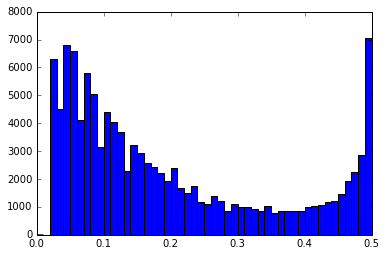

In [273]:
plt.hist(H['h_exp'],bins = [x for x in np.arange(0,.51,0.01)])[2]

In [103]:
h

0.5

In [39]:
len(np.arange(0,0.51,0.01))

51

In [46]:
#see what will happen
#1st bin is the j=0th bin, 50th bin is the j=49th bin
for Bin,j in enumerate(np.arange(0,.51,.01)):
    #print Bin,j
    if 0.50>j: #0.50 don't need their own bin
        print "heyo",Bin,j

heyo 0 0.0
heyo 1 0.01
heyo 2 0.02
heyo 3 0.03
heyo 4 0.04
heyo 5 0.05
heyo 6 0.06
heyo 7 0.07
heyo 8 0.08
heyo 9 0.09
heyo 10 0.1
heyo 11 0.11
heyo 12 0.12
heyo 13 0.13
heyo 14 0.14
heyo 15 0.15
heyo 16 0.16
heyo 17 0.17
heyo 18 0.18
heyo 19 0.19
heyo 20 0.2
heyo 21 0.21
heyo 22 0.22
heyo 23 0.23
heyo 24 0.24
heyo 25 0.25
heyo 26 0.26
heyo 27 0.27
heyo 28 0.28
heyo 29 0.29
heyo 30 0.3
heyo 31 0.31
heyo 32 0.32
heyo 33 0.33
heyo 34 0.34
heyo 35 0.35
heyo 36 0.36
heyo 37 0.37
heyo 38 0.38
heyo 39 0.39
heyo 40 0.4
heyo 41 0.41
heyo 42 0.42
heyo 43 0.43
heyo 44 0.44
heyo 45 0.45
heyo 46 0.46
heyo 47 0.47
heyo 48 0.48
heyo 49 0.49


In [37]:
np.round(H.loc[1043,'h_exp'],decimals=4)

KeyError: 'the label [1043] is not in the [index]'

In [139]:
#assign bins to samps
#1st bin is the j=0th bin, 50th bin is the j=49th bin
count = 0
binDict = OrderedDict()
for row in H.index:
    h = np.round(H.loc[row,'h_exp'],decimals=3)
    binDict[row] = 0 #because 2pq will never be equal to 0 for a SNP, but may be less than 0.01
    for Bin,j in enumerate(np.arange(0,0.51,0.01)): #1st bin is the j=0th bin, 50th bin is the j=49th bin
        if h>j: #binDict[row] will constantly replace the value, which is good. don't want 2pq=0.5 having its own group
            binDict[row] = Bin
    count += 1
    if count % 1000 == 0:
        print count

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000


In [141]:
len(np.unique(binDict.values()).tolist()) # how many bins

49

In [148]:
binDict.values()[:10],binDict.values()[-10:]

([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [49, 49, 49, 49, 49, 49, 49, 49, 49, 49])

In [239]:
H['bin'] = binDict.values()

In [240]:
H.head()

,locus,h_exp,bin
NODE_1274178_length_97_cov_1.030928_97,NODE_1274178_length_97_cov_1.030928_97,0.020282,1
NODE_694898_length_99_cov_1.676768_19,NODE_694898_length_99_cov_1.676768_19,0.020282,1
NODE_544568_length_93_cov_4.064516_12,NODE_544568_length_93_cov_4.064516_12,0.020282,1
NODE_1278450_length_97_cov_2.000000_111,NODE_1278450_length_97_cov_2.000000_111,0.020282,1
NODE_1913585_length_92_cov_1.750000_37,NODE_1913585_length_92_cov_1.750000_37,0.020282,1


In [149]:
np.unique(H['bin'])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [79]:
#write the file
filE = '/home/lindb/wbp/OutFLANK/Hexp_by_snp_withbins.txt'
H.to_csv(filE,header=True,index=True,sep='\t')

In [30]:
#read back the file
filE = '/home/lindb/wbp/OutFLANK/Hexp_by_snp_withbins.txt'
H = pd.read_csv(filE, header=0,index_col=0,sep='\t')

In [276]:
from matplotlib.backends.backend_pdf import PdfPages

In [288]:
H.head()

,locus,h_exp,bin
NODE_1274178_length_97_cov_1.030928_97,NODE_1274178_length_97_cov_1.030928_97,0.020282,1
NODE_694898_length_99_cov_1.676768_19,NODE_694898_length_99_cov_1.676768_19,0.020282,1
NODE_544568_length_93_cov_4.064516_12,NODE_544568_length_93_cov_4.064516_12,0.020282,1
NODE_1278450_length_97_cov_2.000000_111,NODE_1278450_length_97_cov_2.000000_111,0.020282,1
NODE_1913585_length_92_cov_1.750000_37,NODE_1913585_length_92_cov_1.750000_37,0.020282,1


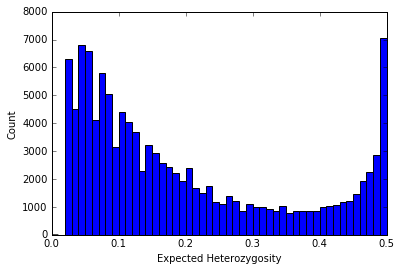

In [290]:
with PdfPages('/home/lindb/wbp/OutFLANK/figures/expected_heterozygosit_all_SNPs.pdf') as pdf:
    fig = plt.figure()
    plt.hist(H['h_exp'],bins = [x for x in np.arange(0,0.51,0.01)])[2]
    plt.xlabel('Expected Heterozygosity')
    plt.ylabel('Count')
    #set_size_inches(5,5)
    pdf.savefig(fig,bbox_inches='tight')

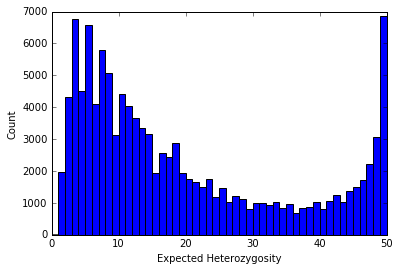

In [281]:
with PdfPages('/home/lindb/wbp/OutFLANK/figures/expected_heterozygosit_all_SNPs.pdf') as pdf:
    fig = plt.figure()
    plt.hist(H['bin'],bins = [x for x in range(51)])[2]
    plt.xlabel('Expected Heterozygosity')
    plt.ylabel('Count')
    #set_size_inches(5,5)
    pdf.savefig(fig,bbox_inches='tight')

In [306]:
len(H.index)

116231

# make minor allele freq dataframe

In [7]:
#get allele counts by pop - first locus = counts of 0 allele, second = counts of 2 allele
    #012 counts global minor allele
counts = pd.read_csv('/home/lindb/wbp/bayenv2/UnbinnedImputedSNPSFILE.txt',header=0,index_col=0,sep="\t")
counts.head()

,Dicks_Pass,Freel_Peak,Heavenly,Little_Round_Top,Mt_Rose_Ophir,Rifle_Peak,Snow_Valley_Peak,West_Shore_Peaks
NODE_1000013_length_91_cov_1.802198_37,43,91,43,42,87,42,41,40
NODE_1000013_length_91_cov_1.802198_37,7,5,7,8,11,6,7,8
NODE_1000031_length_98_cov_2.000000_30,37,86,41,40,90,42,41,37
NODE_1000031_length_98_cov_2.000000_30,13,10,9,10,8,6,7,11
NODE_1000037_length_93_cov_2.043011_33,46,85,43,42,88,42,40,42


In [5]:
#first row + second row of DataFrame(counts)
43+91+43+42+87+42+41+40+7+5+7+8+11+6+7+8

488

In [22]:
df = pd.DataFrame(counts.loc['NODE_1000013_length_91_cov_1.802198_37',:])
df.index = ['major','minor']
df

,Dicks_Pass,Freel_Peak,Heavenly,Little_Round_Top,Mt_Rose_Ophir,Rifle_Peak,Snow_Valley_Peak,West_Shore_Peaks
major,43,91,43,42,87,42,41,40
minor,7,5,7,8,11,6,7,8


In [23]:
sum(df['Dicks_Pass'])

50

In [24]:
df.loc['minor','Dicks_Pass']/sum(df['Dicks_Pass'])

0.14000000000000001

In [67]:
#(my notebook is on a slow node)
#make minor allele freq dataframe
text = '''from __future__ import division
import os
from collections import OrderedDict,Counter
import pandas as pd
import numpy as np
import random

f2 = '/home/lindb/wbp/OutFLANK/update_maf.txt'
with open(f2,'w') as o:
    text = 'starting\\n'
    o.write("%s" % text)

counts = pd.read_csv('/home/lindb/wbp/bayenv2/UnbinnedImputedSNPSFILE.txt',header=0,index_col=0,sep="\\t")
loci = np.unique(counts.index).tolist()

loccount = 0
mafDict = OrderedDict()
for locus in loci:
    mafDict[locus] = OrderedDict()
    data = pd.DataFrame(counts.loc[locus,:])
    data.index = ['major','minor']
    for pop in data.columns:
        MAF = data.loc['minor',pop]/sum(data[pop]) #get allele freq corresponding to global minor allele
        mafDict[locus][pop] = MAF
    loccount += 1
    if loccount % 1000 == 0:
        with open(f2,'a') as o:
            text = "%s" % str(loccount)
            o.write("%s\\n" % text)
        print loccount

with open(f2,'a') as o:
    text = 'writing file\\n'
    o.write("%s" % text)

filE = '/home/lindb/wbp/OutFLANK/imputed_MAF.txt'
with open(filE,'w') as o:
    text = '\\t'.join([x for x in mafDict[mafDict.keys()[0]].keys()]) + '\\n'
    o.write("%s" % text)
    print text
    count = 0
    for locus in mafDict.keys():
        text = locus + '\\t' + '\\t'.join([str(x) for x in mafDict[locus].values()]) + '\\n'
        o.write("%s" % text)
        count += 1
'''

In [68]:
filE = '/home/lindb/wbp/OutFLANK/maf.py'
with open(filE,'w') as o:
    o.write("%s" % text)

In [66]:
shtext = '''#!/bin/bash
#$ -N maf
#$ -V
#$ -j y
#$ -cwd

cd /home/lindb/wbp/OutFLANK/
python maf.py

'''
filE = '/home/lindb/wbp/OutFLANK/get_maf.sh'
with open(filE,'w') as o:
    o.write("%s" % shtext)

In [123]:
!qsub /home/lindb/wbp/OutFLANK/get_maf.sh

In [8]:
outliersnps = snps['x'].tolist()
len(outliersnps)

110

In [163]:
outliersnps

['NODE_1001690_length_90_cov_2.000000_37',
 'NODE_1012475_length_88_cov_1.022727_43',
 'NODE_1025193_length_75_cov_1.093333_47',
 'NODE_1030410_length_81_cov_1.259259_40',
 'NODE_1038234_length_92_cov_1.000000_53',
 'NODE_1063087_length_97_cov_1.639175_100',
 'NODE_107570_length_80_cov_1.350000_43',
 'NODE_1082793_length_76_cov_1.026316_38',
 'NODE_1090835_length_51_cov_1.921569_62',
 'NODE_1092275_length_98_cov_3.897959_107',
 'NODE_1109529_length_96_cov_1.833333_15',
 'NODE_1127778_length_90_cov_1.122222_132',
 'NODE_1138926_length_98_cov_2.000000_89',
 'NODE_116690_length_74_cov_1.472973_41',
 'NODE_1167253_length_98_cov_5.122449_20',
 'NODE_1174675_length_78_cov_1.025641_35',
 'NODE_1176140_length_98_cov_2.000000_7',
 'NODE_1207375_length_94_cov_1.000000_114',
 'NODE_1238761_length_100_cov_1.700000_23',
 'NODE_1247512_length_46_cov_1.021739_38',
 'NODE_1254517_length_98_cov_2.000000_81',
 'NODE_1265845_length_124_cov_1.145161_45',
 'NODE_1285422_length_94_cov_2.414894_29',
 'NODE_1

In [27]:
impMAF = pd.read_csv('/home/lindb/wbp/OutFLANK/imputed_MAF.txt',header=0,index_col=0,sep="\t")
impMAF.head()

,Dicks_Pass,Freel_Peak,Heavenly,Little_Round_Top,Mt_Rose_Ophir,Rifle_Peak,Snow_Valley_Peak,West_Shore_Peaks
NODE_1000013_length_91_cov_1.802198_37,0.14,0.052083,0.14,0.16,0.112245,0.1250,0.145833,0.166667
NODE_1000031_length_98_cov_2.000000_30,0.26,0.104167,0.18,0.20,0.081633,0.1250,0.145833,0.229167
NODE_1000037_length_93_cov_2.043011_33,0.08,0.114583,0.14,0.16,0.102041,0.1250,0.166667,0.125000
NODE_1000042_length_93_cov_1.118280_100,0.06,0.020833,0.08,0.02,0.051020,0.0000,0.041667,0.062500
NODE_1000053_length_94_cov_1.744681_25,0.02,0.020833,0.04,0.02,0.010204,0.0625,0.020833,0.020833


In [77]:
filE= '/home/lindb/wbp/OutFLANK/imputed_MAF.txt'
impMAF.to_csv(filE,header=True,index=True,sep='\t')

In [76]:
impMAF.head()

,Dicks_Pass,Freel_Peak,Heavenly,Little_Round_Top,Mt_Rose_Ophir,Rifle_Peak,Snow_Valley_Peak,West_Shore_Peaks
NODE_1000013_length_91_cov_1.802198_37,0.14,0.052083,0.14,0.16,0.112245,0.1250,0.145833,0.166667
NODE_1000031_length_98_cov_2.000000_30,0.26,0.104167,0.18,0.20,0.081633,0.1250,0.145833,0.229167
NODE_1000037_length_93_cov_2.043011_33,0.08,0.114583,0.14,0.16,0.102041,0.1250,0.166667,0.125000
NODE_1000042_length_93_cov_1.118280_100,0.06,0.020833,0.08,0.02,0.051020,0.0000,0.041667,0.062500
NODE_1000053_length_94_cov_1.744681_25,0.02,0.020833,0.04,0.02,0.010204,0.0625,0.020833,0.020833


In [29]:
impMAF.shape

(116231, 8)

In [28]:
for pop in impMAF.columns:
    print pop,min(impMAF[pop]),max(impMAF[pop])

Dicks_Pass 0.0 0.74
Freel_Peak 0.0 0.65625
Heavenly 0.0 0.8
Little_Round_Top 0.0 0.74
Mt_Rose_Ophir 0.0 0.663265306122
Rifle_Peak 0.0 0.6875
Snow_Valley_Peak 0.0 0.75
West_Shore_Peaks 0.0 0.729166666667


# get global maf allele freqs

In [44]:
glob = OrderedDict() 
count = 0
for snp in imp012.columns:
    zero = imp012[snp].tolist().count(0)
    one  = imp012[snp].tolist().count(1)
    two  = imp012[snp].tolist().count(2)
    
    a1 = ((2*zero)+one)/(2*(zero+one+two))
    a2 = ((2*two)+one)/(2*(zero+one+two))
    
    q = min(a1,a2)
    
    glob[snp] = q
    
    count +=1 
    if count % 10000 == 0:
        print count

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000


In [45]:
len(glob.keys())

116231

In [46]:
filE = '/home/lindb/wbp/OutFLANK/global_mafs.txt'
with open(filE,'w') as o:
    text = '\t'.join(['locus','maf'])+'\n'
    o.write("%s" % text)
    for snp in glob.keys():
        text = '\t'.join([snp,str(glob[snp])])+'\n'
        o.write("%s" % text)
globmafs = pd.read_csv(filE,header=0,sep='\t')
globmafs.head()

,locus,maf
0,NODE_1000013_length_91_cov_1.802198_37,0.120902
1,NODE_1000031_length_98_cov_2.000000_30,0.151639
2,NODE_1000037_length_93_cov_2.043011_33,0.122951
3,NODE_1000042_length_93_cov_1.118280_100,0.040984
4,NODE_1000053_length_94_cov_1.744681_25,0.024590


In [31]:
H.head()

,locus,h_exp,bin
NODE_1274178_length_97_cov_1.030928_97,NODE_1274178_length_97_cov_1.030928_97,0.020282,1
NODE_694898_length_99_cov_1.676768_19,NODE_694898_length_99_cov_1.676768_19,0.020282,1
NODE_544568_length_93_cov_4.064516_12,NODE_544568_length_93_cov_4.064516_12,0.020282,1
NODE_1278450_length_97_cov_2.000000_111,NODE_1278450_length_97_cov_2.000000_111,0.020282,1
NODE_1913585_length_92_cov_1.750000_37,NODE_1913585_length_92_cov_1.750000_37,0.020282,1


In [36]:
#make sure global allele freq and H_exp make sense
H.loc['NODE_1000031_length_98_cov_2.000000_30','h_exp']

0.25728970706799997

In [37]:
2*0.151639*(1-0.151639)

0.257289227358

In [208]:
len(globmafs.index)

116231

# get pop sizes

In [52]:
filE = '/home/lindb/wbp/sampsTOpop.txt'
stp = pd.read_csv(filE,header=0,sep="\t")
stp.head()

,sampID,pop,plot
0,028compiled,Dicks_Pass,3
1,024compiled,Dicks_Pass,2
2,020compiled,Dicks_Pass,2
3,025compiled,Dicks_Pass,2
4,023compiled,Dicks_Pass,2


In [53]:
#pops matched to samps
ptsDict = OrderedDict() #pop to samp dictionary
for row in stp.index:
    pop = stp.loc[row,'pop']
    if not pop in ptsDict.keys():
        ptsDict[pop] = []
    ptsDict[pop].append(stp.loc[row,'sampID'])
for pop in ptsDict.keys():
    print pop,len(ptsDict[pop])

Dicks_Pass 25
Freel_Peak 48
Little_Round_Top 25
Heavenly 25
Mt_Rose_Ophir 49
Rifle_Peak 24
Snow_Valley_Peak 24
West_Shore_Peaks 24


In [54]:
#get a dict with num indiv in pop
popDict = OrderedDict()
total = 0
for pop in ptsDict.keys():
    popDict[pop] = len(ptsDict[pop])
    print pop,popDict[pop]
    total += popDict[pop]
total

Dicks_Pass 25
Freel_Peak 48
Little_Round_Top 25
Heavenly 25
Mt_Rose_Ophir 49
Rifle_Peak 24
Snow_Valley_Peak 24
West_Shore_Peaks 24


244

# covariances using H_exp

In [48]:
snps = pd.read_csv('/home/lindb/wbp/OutFLANK/OutFLANK_snps.txt',header=0,sep='\t')
outliersnps = snps['x'].tolist()

In [65]:
filE = '/home/lindb/wbp/OutFLANK/OutFLANK_snps.txt'
snps.to_csv(filE,header=True,index=False,sep='\t')

In [49]:
len(outliersnps)

110

    D_ij = sum { (nk/n)*((qik*qjk)-(qi*qj)) } for 1:k pops
    qik = snp i maf for pop k
    qik = snp j maf for pop k
    
    qi = global maf
    qj = global maf

In [55]:
#do pairwise to get D
dijDict = OrderedDict() 
icount = 0
for i,locusi in enumerate(outliersnps):
    dijDict[locusi] = OrderedDict()
    qi = glob[locusi] #global maf
    
    for j,locusj in enumerate(outliersnps):
        if i > j: #i=row, j=col : lower triangle 
            qj = glob[locusj] #global maf
            
            sums = 0
            for pop in impMAF.columns:
                qik = impMAF.loc[locusi,pop] #get pop maf
                qjk = impMAF.loc[locusj,pop] #get pop maf
                nk = popDict[pop]
                
                sums += (nk/244)*((qik*qjk)-(qi*qj))

            dijDict[locusi][locusj] = sums
        else:
            dijDict[locusi][locusj] = np.nan
    icount += 1
    if icount % 10 == 0:
        print icount

10
20
30
40
50
60
70
80
90
100
110


In [56]:
#write out the file
rowcount = 0
filE = '/home/lindb/wbp/OutFLANK/covariances/dvals/imputed_dvals.txt'
if not op.exists(op.dirname(filE)):
    os.makedirs(op.dirname(filE))
with open(filE,'w') as o:
    key0 = dijDict.keys()[0]
    line = '\t'.join(dijDict[key0].keys()) + str('\n')
    o.write("%s" % line)
    for locusi in dijDict.keys():
        line = str(locusi)+'\t'+'\t'.join([str(x) for x in dijDict[locusi].values()]) + str('\n')
        o.write("%s" % line)

In [57]:
dvals = pd.read_csv(filE,header=0,index_col=0,sep="\t")
dvals.head()

,NODE_1001690_length_90_cov_2.000000_37,NODE_1012475_length_88_cov_1.022727_43,NODE_1025193_length_75_cov_1.093333_47,NODE_1030410_length_81_cov_1.259259_40,NODE_1038234_length_92_cov_1.000000_53,NODE_1063087_length_97_cov_1.639175_100,NODE_107570_length_80_cov_1.350000_43,NODE_1082793_length_76_cov_1.026316_38,NODE_1090835_length_51_cov_1.921569_62,NODE_1092275_length_98_cov_3.897959_107,...,NODE_861529_length_116_cov_1.318966_103,NODE_866842_length_48_cov_1.229167_34,NODE_880604_length_66_cov_1.363636_44,NODE_893311_length_93_cov_2.000000_109,NODE_897315_length_77_cov_1.337662_38,NODE_904862_length_47_cov_1.382979_41,NODE_923338_length_97_cov_3.154639_15,NODE_983665_length_98_cov_2.000000_96,NODE_987313_length_98_cov_4.653061_59,NODE_988447_length_96_cov_2.697917_32
NODE_1001690_length_90_cov_2.000000_37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NODE_1012475_length_88_cov_1.022727_43,0.005430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NODE_1025193_length_75_cov_1.093333_47,0.006523,0.020351,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NODE_1030410_length_81_cov_1.259259_40,0.003342,0.015638,0.018560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NODE_1038234_length_92_cov_1.000000_53,0.004104,0.011751,0.015875,0.012073,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [284]:
#get a dataframe with the outlier loci and their bins
outlierdata = pd.DataFrame(H[H['locus'].isin(outliersnps)])
outlierdata.index = [snp for snp in outlierdata['locus'].tolist()]
outlierdata.head()

,locus,h_exp,bin
NODE_479598_length_98_cov_4.500000_111,NODE_479598_length_98_cov_4.500000_111,0.020282,1
NODE_1176140_length_98_cov_2.000000_7,NODE_1176140_length_98_cov_2.000000_7,0.028277,2
NODE_429155_length_97_cov_1.000000_48,NODE_429155_length_97_cov_1.000000_48,0.028277,2
NODE_843063_length_96_cov_1.010417_101,NODE_843063_length_96_cov_1.010417_101,0.032249,3
NODE_1640732_length_98_cov_3.653061_29,NODE_1640732_length_98_cov_3.653061_29,0.040144,3


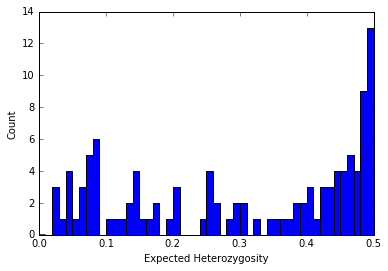

In [285]:
with PdfPages('/home/lindb/wbp/OutFLANK/figures/expected_heterozygosit_outlier_SNPs.pdf') as pdf:
    fig = plt.figure()
    plt.hist(outlierdata['h_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]
    plt.xlabel('Expected Heterozygosity')
    plt.ylabel('Count')
    #set_size_inches(5,5)
    pdf.savefig(fig,bbox_inches='tight')

<a list of 50 Patch objects>

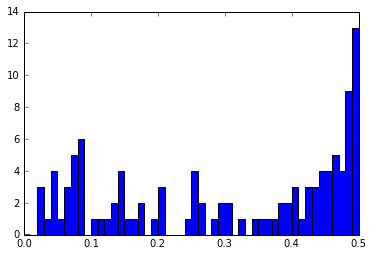

In [275]:
plt.hist(outlierdata['h_exp'].tolist(),bins = [binn for binn in np.arange(0,0.51,0.01)])[2]

In [314]:
nonsigs = set(H.index.tolist()) - set(outlierdata.index.tolist())
nonsigs = [x for x in nonsigs]
len(nonsigs)

116121

In [315]:
nonsigdata = pd.DataFrame(H[H['locus'].isin(nonsigs)])
nonsigdata.shape

(116121, 3)

In [231]:
#how many random snps from each bin?
binCounter = Counter()
for row in outlierdata.index:
    binCounter[outlierdata.loc[row,'bin']] += 1
for b in binCounter.keys():
    print b,binCounter[b]

1 1
2 2
3 3
4 2
5 1
6 3
7 5
8 6
10 1
11 1
12 1
13 3
14 3
15 1
16 1
17 2
19 2
20 2
24 1
25 5
26 1
28 2
29 1
30 2
32 1
34 1
35 1
36 1
37 1
38 2
39 2
40 3
41 1
42 3
43 3
44 5
45 3
46 5
47 4
48 9
49 13


In [316]:
#make 1000 dataframes with a set of snps == 110 = len(outliersnps)
for i in range(20):                                  #make 20 .py files
    for j in range(50):                              #each .py file makes 50 matrices
        snps = []        
        for binn in binCounter.keys():
            data = nonsigdata[nonsigdata['bin'] == binn]
            
            [snps.append(snp) for snp in random.sample(data.index,binCounter[binn])]
        
        print len(snps)
        DIR = '/home/lindb/wbp/OutFLANK/covariances/randmatrices/randsnps'
        if not op.exists(DIR):
            os.makedirs(DIR)
        filE = op.join(DIR,"outflank_%s_%s_randsnps.txt" % (str(i).zfill(2),str(j).zfill(2)))
        df = pd.DataFrame(snps)
        df.to_csv(filE,header=False,index=False,sep="\t")

110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110
110


In [331]:
stp.head()

,sampID,pop,plot
0,028compiled,Dicks_Pass,3
1,024compiled,Dicks_Pass,2
2,020compiled,Dicks_Pass,2
3,025compiled,Dicks_Pass,2
4,023compiled,Dicks_Pass,2


In [332]:
#I'm using all of my engines for bayenv2 at the moment, ran these with GNU parallel
#get dvals for 1000 sets of random snps of len=110
for k in range(20):
    for l in range(50):
        text = '''from __future__ import division
import os
from collections import OrderedDict,Counter
import pandas as pd
import numpy as np
import vcf
from operator import itemgetter
import random
import math
from scipy.stats import ks_2samp
from scipy.stats import anderson_ksamp
from os import path as op
from os import listdir as ls

#get pop assignment for each samp
filE = '/home/lindb/wbp/sampsTOpop.txt'
stp = pd.read_csv(filE,header=0,sep="\t")


#pops matched to samps
ptsDict = OrderedDict() #pop to samp dictionary
for row in stp.index:
    pop = stp.loc[row,'pop']
    if not pop in ptsDict.keys():
        ptsDict[pop] = []
    ptsDict[pop].append(stp.loc[row,'sampID'])


#get a dict with num indiv in pop
popDict = OrderedDict()
total = 0
for pop in ptsDict.keys():
    popDict[pop] = len(ptsDict[pop])
    print pop,popDict[pop]
    total += popDict[pop]


filE = '/home/lindb/wbp/OutFLANK/global_mafs.txt'
globs = pd.read_csv(filE,header=0,sep='\\t')
glob = OrderedDict()
for row in globs.index:
    snp = globs.loc[row,'locus']
    maf = globs.loc[row,'maf']
    glob[snp] = maf

impMAF = pd.read_csv('/home/lindb/wbp/OutFLANK/imputed_MAF.txt',header=0,index_col=0,sep="\\t")

filE= '/home/lindb/wbp/OutFLANK/covariances/randmatrices/randsnps/outflank_%s_%s_randsnps.txt' 
df = pd.read_csv(filE,header=None,sep="\\t")
randomsnps = df[0].tolist()

dijDict = OrderedDict() 
for i,locusi in enumerate(randomsnps):
    dijDict[locusi] = OrderedDict()
    qi = glob[locusi] #global maf

    for j,locusj in enumerate(randomsnps):
        if i > j: #i=row, j=col : lower triangle 
            qj = glob[locusj] #global maf

            sums = 0
            for pop in impMAF.columns:
                qik = impMAF.loc[locusi,pop] #get pop maf
                qjk = impMAF.loc[locusj,pop] #get pop maf
                nk = popDict[pop]

                sums += (nk/sum(popDict.values()))*((qik*qjk)-(qi*qj))

            dijDict[locusi][locusj] = sums
        else:
            dijDict[locusi][locusj] = np.nan

filE = '/home/lindb/wbp/OutFLANK/covariances/randmatrices/0outfiles/outflank_%s_%s_imputedDVALS.txt'
DIR = os.path.dirname(filE)
if not os.path.exists(DIR):
    os.makedirs(DIR)

with open(filE,'w') as o:
    key0 = dijDict.keys()[0]
    line = '\\t'.join(dijDict[key0].keys()) + str('\\n')
    o.write("%%s" %% line)
    for locusi in dijDict.keys():
        line = str(locusi)+'\\t'+'\\t'.join([str(x) for x in dijDict[locusi].values()]) + str('\\n')
        o.write("%%s" %% line)


''' % (str(k).zfill(2),str(l).zfill(2),
       str(k).zfill(2),str(l).zfill(2))
        filE = '/home/lindb/wbp/OutFLANK/covariances/randmatrices/0pyfiles/get_rand_dvals_%s_%s.py' % (str(k).zfill(2),
                                                                                                       str(l).zfill(2)
                                                                                                      )
        with open(filE,'w') as o:
            o.write("%s" % text)

In [81]:
#make qsub files
count = 0
shcount = 0
for i in range(20):
    for j in range(50):
        filE = '/home/lindb/wbp/OutFLANK/covariances/randmatrices/0pyfiles/get_rand_dvals_%s_%s.py' % (str(i).zfill(2),
                                                                                                       str(j).zfill(2)
                                                                                                      )
        if count == 0:
            text = '''#!/bin/bash
#$ -N snpsfile
#$ -V
#$ -j y
#$ -cwd

python %s
''' % filE
        else:
            newtext = '''
python %s
''' % filE
            text = text + newtext
        count += 1
        if count == 40:
            count = 0
            filE = '/home/lindb/wbp/OutFLANK/covariances/randmatrices/0runfiles/%s_run.sh' % str(shcount).zfill(2)
            shcount += 1
            if not op.exists(op.dirname(filE)):
                os.makedirs(op.dirname(filE))
            with open(filE,'w') as o:
                o.write("%s" % text)

### place median observed dij in distribution of median dij for random snps

In [85]:
# get observed dvals
DF = pd.read_csv('/home/lindb/wbp/OutFLANK/covariances/dvals/imputed_dvals.txt',header=0,index_col=0,sep="\t")
dvals = []
for i,row in enumerate(DF.index):
    for j,col in enumerate(DF.columns):
        if i > j:
            dvals.append(abs(DF.loc[row,col]))
            
DIR = '/home/lindb/wbp/OutFLANK/covariances/randmatrices/0outfiles'
files = os.listdir(DIR)
files = [f for f in files if f.startswith('outflank')]

fcount = 0
medvals = []
for f in files:
    df = pd.read_csv(os.path.join(DIR,f),header=0,index_col=0,sep="\t")
    rvals = [] #random dij values
    for i,row in enumerate(df.index):
        for j,col in enumerate(df.columns):
            if i>j:
                rvals.append(df.loc[row,col])

    
    medvals.append(np.median([abs(x) for x in rvals]))

    fcount += 1
    if fcount % 100 == 0:
        print fcount

filE = '/home/lindb/wbp/OutFLANK/covariances/randmatrices/0randmedvals/outflank_imputed_randmedvalues.txt'
if not op.exists(op.dirname(filE)):
    os.makedirs(op.dirname(filE))
medvals = pd.DataFrame(medvals)
medvals.to_csv(filE,header=None,index=False,sep="\t")

100
200
300
400
500
600
700
800
900
1000


In [ ]:
1+1

In [86]:
medDF = pd.read_csv(filE,header=None,sep='\t')
medDF.head()

,0
0,0.000446
1,0.000462
2,0.000450
3,0.000511
4,0.000429


In [87]:
sorts = sorted(medvals[0].tolist())
n5th = sorts[949] #95th percentile

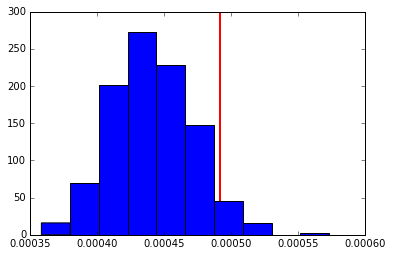

In [89]:
#this is the distribution of median values of random SNPs
#red line is the 95th percentile (95th = 0.0006213)
plt.hist(sorts)[2] 
plt.axvline(x=n5th,c="red",linewidth=2,zorder=0) #should be zorder=1 

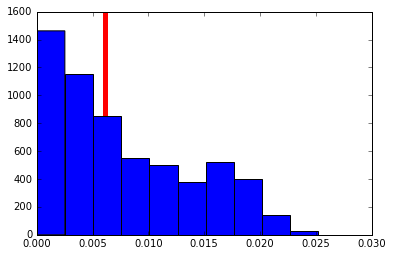

In [90]:
#this is the distribution of observed Dvals
#red line is the median value (median = 0.0043892)
med = np.median(dvals)
fig = plt.hist(dvals)[2]
plt.axvline(x=med,c="red",linewidth=5,zorder=0)

In [91]:
#how much bigger is the empirical median dvalue than the 100th percentile of random SNPs?
np.median(dvals)/max(sorts)

10.610076816148037

In [92]:
np.median(dvals)/n5th

12.376278242077095

In [93]:
len(dvals)

5995

In [137]:
med

0.0060805992646700002

In [141]:
#below what percentile of the observed dvals less than the maximum randdvals
for i,medi in enumerate(sorted(dvals)):
    if not medi < max(sorts):
        print i,i/len(dvals)
        break      

449 0.0748957464554


In [96]:
#below what percentile of the observed dvals are the values less than the 95th perc randdvals
for i,D in enumerate(sorted(dvals)):
    if not D < sorts[950]: #if the observed D-value isn't less than the 95th percentile of the random distribution of D
        print i,i/len(dvals)
        break

389 0.0648874061718


In [138]:
max(sorts),med

(0.00057309662974500001, 0.0060805992646700002)

In [139]:
n5th,med

(0.00049131080812300006, 0.0060805992646700002)

# allele frequency shifts

### using median abs Dij

In [99]:
#dataframe to get population MAF across 8 pops using all n=244 samples (can't use this for GEMMA since pop sizes r diff
impMAF.head()

,Dicks_Pass,Freel_Peak,Heavenly,Little_Round_Top,Mt_Rose_Ophir,Rifle_Peak,Snow_Valley_Peak,West_Shore_Peaks
NODE_1000013_length_91_cov_1.802198_37,0.14,0.052083,0.14,0.16,0.112245,0.1250,0.145833,0.166667
NODE_1000031_length_98_cov_2.000000_30,0.26,0.104167,0.18,0.20,0.081633,0.1250,0.145833,0.229167
NODE_1000037_length_93_cov_2.043011_33,0.08,0.114583,0.14,0.16,0.102041,0.1250,0.166667,0.125000
NODE_1000042_length_93_cov_1.118280_100,0.06,0.020833,0.08,0.02,0.051020,0.0000,0.041667,0.062500
NODE_1000053_length_94_cov_1.744681_25,0.02,0.020833,0.04,0.02,0.010204,0.0625,0.020833,0.020833


In [100]:
#population sizes
popDict

OrderedDict([('Dicks_Pass', 25),
             ('Freel_Peak', 48),
             ('Little_Round_Top', 25),
             ('Heavenly', 25),
             ('Mt_Rose_Ophir', 49),
             ('Rifle_Peak', 24),
             ('Snow_Valley_Peak', 24),
             ('West_Shore_Peaks', 24)])

In [323]:
len(outliersnps)

110

In [101]:
#do pairwise pops for empirical SNPs IDed by OutFLANK and calculate median Dij for each pop pair
shiftDict = OrderedDict() 
kcount = 0
for m,popm in enumerate(impMAF.columns):
    print popm
    shiftDict[popm] = OrderedDict()
    for l,popl in enumerate(impMAF.columns):
        if m>l: #only need to do the lower triangle
            dijlist = []
            for i,locusi in enumerate(outliersnps):
                for j,locusj in enumerate(outliersnps):
                    if i > j: #i=row, j=col : lower triangle 
                        sums =0
                        kcount += 1
                        for popk in [popm,popl]:
                            qik = impMAF.loc[locusi,popk]        #get locusi maf for pop k
                            qjk = impMAF.loc[locusj,popk]        #get locusj maf for pop k
                            nk = popDict[popk]                   #N  individuals  in pop k
                            
                            globN = 2*(popDict[popm]+popDict[popl]) # number of alleles across 2 pops
                            
                            #get global mafs
                            fqim = impMAF.loc[locusi,popm]        #minor allele locusi freq  in popm
                            nqim = round(fqim*2*popDict[popm])    #minor allele locusi count in popm
                            fqil = impMAF.loc[locusi,popl]        #minor allele locusi freq  in popl
                            nqil = round(fqil*2*popDict[popl])    #minor allele locusi count in popl
                            
                            fqjm = impMAF.loc[locusj,popm]        #minor allele locusj freq  in popm
                            nqjm = round(fqjm*2*popDict[popm])    #minor allele locusj count in popm
                            fqjl = impMAF.loc[locusj,popl]        #minor allele locusj freq  in popl
                            nqjl = round(fqjl*2*popDict[popl])    #minor allele locusj count in popl
                            
                            qi = (nqim+nqil)/((2*popDict[popm])+(2*popDict[popl])) #global maf locusi
                            qj = (nqjm+nqjl)/((2*popDict[popm])+(2*popDict[popl])) #global maf locusj

                            sums += (nk/(popDict[popm]+popDict[popl]))*((qik*qjk)-(qi*qj))

                        dijlist.append(sums) #each pairwise pop comparison has a matrix of Dij
                    else:
                        pass #no redundancies, no diagonal. 
            shiftDict[popm][popl] = np.median([abs(d) for d in dijlist])
        else:
            shiftDict[popm][popl] = np.nan #no redundancies,no diagonal. will be faster to reflect across diag later
#    if kcount > 1:
#        break

Dicks_Pass
Freel_Peak
Heavenly
Little_Round_Top
Mt_Rose_Ophir
Rifle_Peak
Snow_Valley_Peak
West_Shore_Peaks


In [102]:
filE = '/home/lindb/wbp/OutFLANK/freqshifts/pop_pairwise_dij.text'
with open(filE,'w') as o:
    key0 = shiftDict.keys()[0]
    line = '\t'.join(shiftDict[key0].keys()) + str('\n')
    o.write("%s" % line)
    for popk in shiftDict.keys():
        text = str(popk)+'\t'+'\t'.join([str(d) for d in shiftDict[popk].values()])+'\n'
        o.write("%s" % text)

In [103]:
filE = '/home/lindb/wbp/OutFLANK/freqshifts/pop_pairwise_dij.text'
shiftDF = pd.read_csv(filE,header=0,index_col=0,sep='\t')
shiftDF

,Dicks_Pass,Freel_Peak,Heavenly,Little_Round_Top,Mt_Rose_Ophir,Rifle_Peak,Snow_Valley_Peak,West_Shore_Peaks
Dicks_Pass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Freel_Peak,0.006703,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Heavenly,0.002600,0.006422,NaN,NaN,NaN,NaN,NaN,NaN
Little_Round_Top,0.007000,0.000522,0.008500,NaN,NaN,NaN,NaN,NaN
Mt_Rose_Ophir,0.007560,0.000307,0.008609,0.000710,NaN,NaN,NaN,NaN
Rifle_Peak,0.006247,0.000193,0.008668,0.000529,0.000317,NaN,NaN,NaN
Snow_Valley_Peak,0.015165,0.000772,0.016198,0.002124,0.000797,0.00076,NaN,NaN
West_Shore_Peaks,0.008131,0.000603,0.009341,0.000994,0.000232,0.00076,0.001302,NaN


In [105]:
shifts = []
for i,row in enumerate(shiftDF.index):
    for j,col in enumerate(shiftDF.columns):
        if i > j:
            shifts.append(shiftDF.loc[row,col])

In [106]:
for i,popi in enumerate(shiftDF.index):
    for j,popj in enumerate(shiftDF.columns):
        if i == j:
            shiftDF.loc[popi,popj] =0
        elif math.isnan(shiftDF.loc[popi,popj]) == True:
            shiftDF.loc[popi,popj] = shiftDF.loc[popj,popi]
shiftDF

,Dicks_Pass,Freel_Peak,Heavenly,Little_Round_Top,Mt_Rose_Ophir,Rifle_Peak,Snow_Valley_Peak,West_Shore_Peaks
Dicks_Pass,0.000000,0.006703,0.002600,0.007000,0.007560,0.006247,0.015165,0.008131
Freel_Peak,0.006703,0.000000,0.006422,0.000522,0.000307,0.000193,0.000772,0.000603
Heavenly,0.002600,0.006422,0.000000,0.008500,0.008609,0.008668,0.016198,0.009341
Little_Round_Top,0.007000,0.000522,0.008500,0.000000,0.000710,0.000529,0.002124,0.000994
Mt_Rose_Ophir,0.007560,0.000307,0.008609,0.000710,0.000000,0.000317,0.000797,0.000232
Rifle_Peak,0.006247,0.000193,0.008668,0.000529,0.000317,0.000000,0.000760,0.000760
Snow_Valley_Peak,0.015165,0.000772,0.016198,0.002124,0.000797,0.000760,0.000000,0.001302
West_Shore_Peaks,0.008131,0.000603,0.009341,0.000994,0.000232,0.000760,0.001302,0.000000


In [107]:
filE = '/home/lindb/wbp/bayenv2/distance_matrices/geographic_distances.txt'
geodist = pd.read_csv(filE,header=0,index_col=0,sep='\t')
geodist

,Dicks_Pass,Freel_Peak,Heavenly,Little_Round_Top,Mt_Rose_Ophir,Rifle_Peak,Snow_Valley_Peak,West_Shore_Peaks
Dicks_Pass,0.000000,20.104666,19.920600,20.154529,46.721875,43.644995,34.872237,7.360111
Freel_Peak,20.104666,0.000000,8.942301,18.012925,48.167873,47.870742,33.436003,22.696565
Heavenly,19.920600,8.942301,0.000000,25.483772,39.233487,39.101996,24.495198,19.398818
Little_Round_Top,20.154529,18.012925,25.483772,0.000000,62.614167,60.896987,48.688896,26.972518
Mt_Rose_Ophir,46.721875,48.167873,39.233487,62.614167,0.000000,6.729816,14.888191,39.846163
Rifle_Peak,43.644995,47.870742,39.101996,60.896987,6.729816,0.000000,16.378662,36.466148
Snow_Valley_Peak,34.872237,33.436003,24.495198,48.688896,14.888191,16.378662,0.000000,28.899038
West_Shore_Peaks,7.360111,22.696565,19.398818,26.972518,39.846163,36.466148,28.899038,0.000000


In [180]:
geodist.loc['Freel_Peak','Dicks_Pass'][:-3]

'20.1046659014'

In [109]:
geos = []
for i,row in enumerate(geodist.index):
    for j,col in enumerate(geodist.columns):
        if i > j:
            geos.append(float(geodist.loc[row,col]))

In [191]:
#get rid of the km
for i,popi in enumerate(geodist.index):
    for j,popj in enumerate(geodist.columns):
        if i>j:
            geodist.loc[popi,popj] = float(geodist.loc[popi,popj][:-3])
geodist

,Dicks_Pass,Freel_Peak,Heavenly,Little_Round_Top,Mt_Rose_Ophir,Rifle_Peak,Snow_Valley_Peak,West_Shore_Peaks
Dicks_Pass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Freel_Peak,20.1047,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Heavenly,19.9206,8.9423,NaN,NaN,NaN,NaN,NaN,NaN
Little_Round_Top,20.1545,18.0129,25.4838,NaN,NaN,NaN,NaN,NaN
Mt_Rose_Ophir,46.7219,48.1679,39.2335,62.6142,NaN,NaN,NaN,NaN
Rifle_Peak,43.645,47.8707,39.102,60.897,6.72982,NaN,NaN,NaN
Snow_Valley_Peak,34.8722,33.436,24.4952,48.6889,14.8882,16.3787,NaN,NaN
West_Shore_Peaks,7.36011,22.6966,19.3988,26.9725,39.8462,36.4661,28.899,NaN


In [192]:
for i,popi in enumerate(geodist.index):
    for j,popj in enumerate(geodist.columns):
        if i == j:
            geodist.loc[popi,popj] = 0
        elif math.isnan(geodist.loc[popi,popj]) == True:
            geodist.loc[popi,popj] = geodist.loc[popj,popi]
geodist

,Dicks_Pass,Freel_Peak,Heavenly,Little_Round_Top,Mt_Rose_Ophir,Rifle_Peak,Snow_Valley_Peak,West_Shore_Peaks
Dicks_Pass,0,20.1047,19.9206,20.1545,46.7219,43.645,34.8722,7.360111
Freel_Peak,20.1047,0,8.9423,18.0129,48.1679,47.8707,33.436,22.696565
Heavenly,19.9206,8.9423,0,25.4838,39.2335,39.102,24.4952,19.398818
Little_Round_Top,20.1545,18.0129,25.4838,0,62.6142,60.897,48.6889,26.972518
Mt_Rose_Ophir,46.7219,48.1679,39.2335,62.6142,0,6.72982,14.8882,39.846163
Rifle_Peak,43.645,47.8707,39.102,60.897,6.72982,0,16.3787,36.466148
Snow_Valley_Peak,34.8722,33.436,24.4952,48.6889,14.8882,16.3787,0,28.899038
West_Shore_Peaks,7.36011,22.6966,19.3988,26.9725,39.8462,36.4661,28.899,0.000000


In [317]:
filE = '/home/lindb/wbp/bayenv2/distance_matrices/geographic_distances.txt'
geodist.to_csv(filE,header=True,index=True,sep='\t')

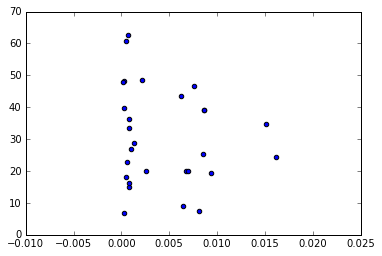

In [110]:
plt.scatter(shifts,geos)

In [111]:
#Mantel shift vs geodist
skbio.stats.distance.mantel(shiftDF,geodist,permutations=9999)

(-0.15843450931736525, 0.35560000000000003, 8)

In [26]:
#file made in 08_bayen2
envdist = pd.read_csv('/home/lindb/wbp/bayenv2/matrices/environmental_distances.txt',header=0,index_col=0,sep='\t')
envdist

,Dicks_Pass,Freel_Peak,Heavenly,Little_Round_Top,Mt_Rose_Ophir,Rifle_Peak,Snow_Valley_Peak,West_Shore_Peaks
Dicks_Pass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Freel_Peak,2.922248,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Heavenly,2.220908,0.701339,NaN,NaN,NaN,NaN,NaN,NaN
Little_Round_Top,4.149592,1.227344,1.928684,NaN,NaN,NaN,NaN,NaN
Mt_Rose_Ophir,0.233780,3.156028,2.454688,4.383372,NaN,NaN,NaN,NaN
Rifle_Peak,3.039138,5.961386,5.260046,7.188730,2.805358,NaN,NaN,NaN
Snow_Valley_Peak,8.299184,11.221432,10.520092,12.448776,8.065404,5.260046,NaN,NaN
West_Shore_Peaks,6.078275,3.156028,3.857367,1.928684,6.312055,9.117413,14.377459,NaN


In [28]:
envs = []
for i,row in enumerate(envdist.index):
    for j,col in enumerate(envdist.columns):
        if i > j:
            envs.append(float(envdist.loc[row,col]))
envs

[2.92224783365,
 2.2209083535799996,
 0.701339480077,
 4.14959192379,
 1.22734409013,
 1.92868357021,
 0.23377982669199998,
 3.1560276603500004,
 2.4546881802700002,
 4.38337175048,
 3.039137747,
 5.96138558066,
 5.26004610058,
 7.18872967079,
 2.8053579203099996,
 8.29918384758,
 11.221431681199999,
 10.5200922012,
 12.448775771400001,
 8.06540402089,
 5.26004610058,
 6.078275494,
 3.1560276603500004,
 3.85736714042,
 1.92868357021,
 6.31205532069,
 9.117413241,
 14.377459341600002]

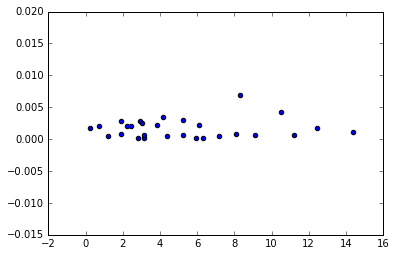

In [331]:
plt.scatter(envs,shifts)

In [244]:
for i,popi in enumerate(envdist.index):
    for j,popj in enumerate(envdist.columns):
        if i == j:
            envdist.loc[popi,popj] = 0
        elif math.isnan(envdist.loc[popi,popj]) == True:
            envdist.loc[popi,popj] = envdist.loc[popj,popi]
envdist

,Dicks_Pass,Freel_Peak,Heavenly,Little_Round_Top,Mt_Rose_Ophir,Rifle_Peak,Snow_Valley_Peak,West_Shore_Peaks
Dicks_Pass,0.000000,2.922248,2.220908,4.149592,0.233780,3.039138,8.299184,6.078275
Freel_Peak,2.922248,0.000000,0.701339,1.227344,3.156028,5.961386,11.221432,3.156028
Heavenly,2.220908,0.701339,0.000000,1.928684,2.454688,5.260046,10.520092,3.857367
Little_Round_Top,4.149592,1.227344,1.928684,0.000000,4.383372,7.188730,12.448776,1.928684
Mt_Rose_Ophir,0.233780,3.156028,2.454688,4.383372,0.000000,2.805358,8.065404,6.312055
Rifle_Peak,3.039138,5.961386,5.260046,7.188730,2.805358,0.000000,5.260046,9.117413
Snow_Valley_Peak,8.299184,11.221432,10.520092,12.448776,8.065404,5.260046,0.000000,14.377459
West_Shore_Peaks,6.078275,3.156028,3.857367,1.928684,6.312055,9.117413,14.377459,0.000000


In [320]:
filE = '/home/lindb/wbp/bayenv2/distance_matrices/environmental_distances.txt'
envdist.to_csv(filE,header=True,index_col=True,sep='\t')

In [113]:
#file made in 08_bayen2
envdist = pd.read_csv('/home/lindb/wbp/bayenv2/distance_matrices/environmental_distances.txt',header=0,index_col=0,sep='\t')
envdist

,Dicks_Pass,Freel_Peak,Heavenly,Little_Round_Top,Mt_Rose_Ophir,Rifle_Peak,Snow_Valley_Peak,West_Shore_Peaks
Dicks_Pass,0.000000,2.922248,2.220908,4.149592,0.233780,3.039138,8.299184,6.078275
Freel_Peak,2.922248,0.000000,0.701339,1.227344,3.156028,5.961386,11.221432,3.156028
Heavenly,2.220908,0.701339,0.000000,1.928684,2.454688,5.260046,10.520092,3.857367
Little_Round_Top,4.149592,1.227344,1.928684,0.000000,4.383372,7.188730,12.448776,1.928684
Mt_Rose_Ophir,0.233780,3.156028,2.454688,4.383372,0.000000,2.805358,8.065404,6.312055
Rifle_Peak,3.039138,5.961386,5.260046,7.188730,2.805358,0.000000,5.260046,9.117413
Snow_Valley_Peak,8.299184,11.221432,10.520092,12.448776,8.065404,5.260046,0.000000,14.377459
West_Shore_Peaks,6.078275,3.156028,3.857367,1.928684,6.312055,9.117413,14.377459,0.000000


In [114]:
#Mantel shift vs total environmental distance
skbio.stats.distance.mantel(shiftDF,envdist,permutations=9999)

(-0.032115581581677079, 0.91669999999999996, 8)

In [115]:
envdf = pd.read_csv('/home/lindb/wbp/bayenv2/ENVIRONFILE_headerIDX.txt',header=0,index_col=0,sep='\t')
envdf = envdf.loc[:,[col for col in envdf.columns[:8]]]
envdf.head()

,Dicks_Pass,Freel_Peak,Heavenly,Little_Round_Top,Mt_Rose_Ophir,Rifle_Peak,Snow_Valley_Peak,West_Shore_Peaks
AWS0-25,-0.203570,-0.389380,-1.384005,0.474087,0.430367,0.299207,1.982420,-1.209126
AWS0-50,-0.035349,-0.578405,-1.156498,0.239933,-0.030344,0.510211,2.176919,-1.126467
Ann-ppt,1.621491,-0.620322,-1.416888,0.058608,-0.059028,0.260270,-1.124478,1.280346
CEC,-0.519958,-0.162005,-0.519958,2.565848,0.195949,-0.519958,-0.519958,-0.519958
Clay,-0.111761,-0.739189,-0.049018,2.429323,-1.209760,-0.033332,-0.017646,-0.268618


In [116]:
#get distance matrices for each of the environmental variables
envdDict = OrderedDict()
for env in envdf.index:
    envdDict[env] = pd.DataFrame(index=[pop for pop in shiftDF.index],columns=[pop for pop in shiftDF.columns])
    for i,popi in enumerate(envdf.columns):
        for j,popj in enumerate(envdf.columns):
            if i != j:
                dist = abs(envdf.loc[env,popi]-envdf.loc[env,popj])
                envdDict[env].loc[popi,popj] = dist
            elif i == j:
                envdDict[env][popi][popj] = 0

In [117]:
envdDict['Ann-ppt']

,Dicks_Pass,Freel_Peak,Heavenly,Little_Round_Top,Mt_Rose_Ophir,Rifle_Peak,Snow_Valley_Peak,West_Shore_Peaks
Dicks_Pass,0,2.24181,3.03838,1.56288,1.68052,1.36122,2.74597,0.341145
Freel_Peak,2.24181,0,0.796566,0.67893,0.561294,0.880592,0.504156,1.90067
Heavenly,3.03838,0.796566,0,1.4755,1.35786,1.67716,0.29241,2.69723
Little_Round_Top,1.56288,0.67893,1.4755,0,0.117636,0.201662,1.18309,1.22174
Mt_Rose_Ophir,1.68052,0.561294,1.35786,0.117636,0,0.319299,1.06545,1.33937
Rifle_Peak,1.36122,0.880592,1.67716,0.201662,0.319299,0,1.38475,1.02008
Snow_Valley_Peak,2.74597,0.504156,0.29241,1.18309,1.06545,1.38475,0,2.40482
West_Shore_Peaks,0.341145,1.90067,2.69723,1.22174,1.33937,1.02008,2.40482,0


In [293]:
os.makedirs('/home/lindb/wbp/distance_matrices/')

In [296]:
for env in envdDict.keys():
    print env
    filE = '/home/lindb/wbp/distance_matrices/%s_dist_symm.txt' % env
    envdDict[env].to_csv(filE,header=True,index=True,sep='\t')

AWS0-25
AWS0-50
Ann-ppt
CEC
Clay
Elev
GDD-Aug
GDD-May
Lat
Lon
Max-rad-input
Rock-cov
Sand
Silt
Tmax-July
Tmin-Jan
WC15Bar
WC3rdbar


In [133]:
#mantel vs individual envs
for env in envdDict:
    mant = mantel(shiftDF,envdDict[env],permutations = 9999)
    print env,mant

AWS0-25 (0.28339662633306506, 0.31969999999999998, 8)
AWS0-50 (0.15855639697724125, 0.68979999999999997, 8)
Ann-ppt (0.28122700978409215, 0.16039999999999999, 8)
CEC (-0.22644229327031271, 0.49299999999999999, 8)
Clay (-0.30403596623729046, 0.34439999999999998, 8)
Elev (-0.080111685348811384, 0.69159999999999999, 8)
GDD-Aug (-0.31389381180668968, 0.0814, 8)
GDD-May (-0.045965057135505388, 0.91459999999999997, 8)
Lat (-0.15790509498595753, 0.42130000000000001, 8)
Lon (0.024769828892832649, 0.83850000000000002, 8)
Max-rad-input (-0.18765549349739241, 0.40210000000000001, 8)
Rock-cov (-0.33822613555529529, 0.18210000000000001, 8)
Sand (-0.11394026866449045, 0.52669999999999995, 8)
Silt (-0.0095027003278365801, 0.96799999999999997, 8)
Tmax-July (0.092395517750101991, 0.61670000000000003, 8)
Tmin-Jan (-0.14650977030646228, 0.57220000000000004, 8)
WC15Bar (0.054043871975656965, 0.90669999999999995, 8)
WC3rdbar (-0.032115581583035444, 0.90820000000000001, 8)


In [130]:
mant

(0.28339662633306506, 0.20000000000000001, 8)

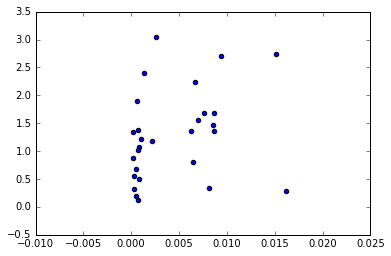

In [118]:
appt = []
for i,popi in enumerate(envdDict['Ann-ppt'].index):
    for j,popj in enumerate(envdDict['Ann-ppt'].columns):
        if i>j:
            appt.append(envdDict['Ann-ppt'].loc[popi,popj])
plt.scatter(shifts,appt)

In [119]:
envdDict.keys()

['AWS0-25',
 'AWS0-50',
 'Ann-ppt',
 'CEC',
 'Clay',
 'Elev',
 'GDD-Aug',
 'GDD-May',
 'Lat',
 'Lon',
 'Max-rad-input',
 'Rock-cov',
 'Sand',
 'Silt',
 'Tmax-July',
 'Tmin-Jan',
 'WC15Bar',
 'WC3rdbar']

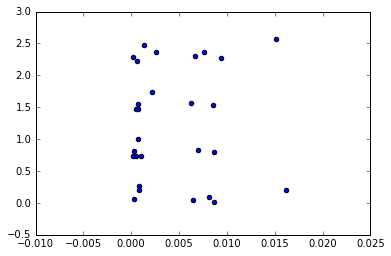

In [120]:
longs = []
for i,popi in enumerate(envdDict['Lon'].index):
    for j,popj in enumerate(envdDict['Lon'].columns):
        if i>j:
            longs.append(envdDict['Lon'].loc[popi,popj])
plt.scatter(shifts,longs)

In [121]:
pearsonr(appt,shifts)

(0.28122700978409221, 0.14713846317584567)

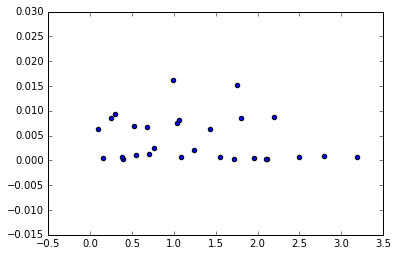

In [122]:
prmi = []
for i,popi in enumerate(envdDict['Max-rad-input'].index):
    for j,popj in enumerate(envdDict['Max-rad-input'].columns):
        if i>j:
            prmi.append(envdDict['Max-rad-input'].loc[popi,popj])
plt.scatter(prmi,shifts)

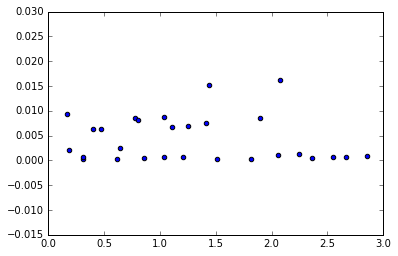

In [123]:
sand = []
for i,popi in enumerate(envdDict['Sand'].index):
    for j,popj in enumerate(envdDict['Sand'].columns):
        if i>j:
            sand.append(envdDict['Sand'].loc[popi,popj])
plt.scatter(sand,shifts)

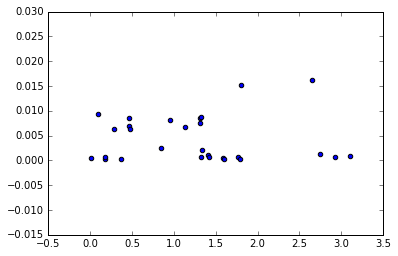

In [124]:
silt = []
for i,popi in enumerate(envdDict['Silt'].index):
    for j,popj in enumerate(envdDict['Silt'].columns):
        if i>j:
            silt.append(envdDict['Silt'].loc[popi,popj])
plt.scatter(silt,shifts)

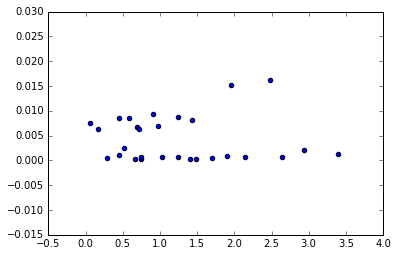

In [125]:
WC3rdbar = []
for i,popi in enumerate(envdDict['WC3rdbar'].index):
    for j,popj in enumerate(envdDict['WC3rdbar'].columns):
        if i>j:
            WC3rdbar.append(envdDict['WC3rdbar'].loc[popi,popj])
plt.scatter(WC3rdbar,shifts)

In [360]:
#test against phenotypic distances
DIR = '/home/lindb/wbp/gemma/distance_matrices'
files = [op.join(DIR,f) for f in ls(DIR)]
phendf = OrderedDict()
for f in files:
    pheno = op.basename(f).split("_")[0]
    phendf[pheno] = pd.read_csv(f,header=0,index_col=0,sep='\t')
phendf[pheno]

,Dicks_Pass,Freel_Peak,Little_Round_Top,Mt_Rose_Ophir,Rifle_Peak,Snow_Valley_Peak
Dicks_Pass,0.000000,0.875842,2.606191,1.598282,2.768496,0.763021
Freel_Peak,0.875842,0.000000,1.730349,0.722440,1.892654,0.112821
Little_Round_Top,2.606191,1.730349,0.000000,1.007910,0.162305,1.843170
Mt_Rose_Ophir,1.598282,0.722440,1.007910,0.000000,1.170214,0.835261
Rifle_Peak,2.768496,1.892654,0.162305,1.170214,0.000000,2.005475
Snow_Valley_Peak,0.763021,0.112821,1.843170,0.835261,2.005475,0.000000


In [128]:
from skbio.stats.distance import mantel

In [364]:
shiftDF

,Dicks_Pass,Freel_Peak,Heavenly,Little_Round_Top,Mt_Rose_Ophir,Rifle_Peak,Snow_Valley_Peak,West_Shore_Peaks
Dicks_Pass,0.000000,0.002867,0.002000,0.003500,0.001697,0.002599,0.006875,0.002251
Freel_Peak,0.002867,0.000000,0.002071,0.000445,0.000258,0.000169,0.000627,0.000579
Heavenly,0.002000,0.002071,0.000000,0.002800,0.001995,0.003015,0.004258,0.002224
Little_Round_Top,0.003500,0.000445,0.002800,0.000000,0.000471,0.000487,0.001688,0.000833
Mt_Rose_Ophir,0.001697,0.000258,0.001995,0.000471,0.000000,0.000257,0.000774,0.000230
Rifle_Peak,0.002599,0.000169,0.003015,0.000487,0.000257,0.000000,0.000651,0.000651
Snow_Valley_Peak,0.006875,0.000627,0.004258,0.001688,0.000774,0.000651,0.000000,0.001085
West_Shore_Peaks,0.002251,0.000579,0.002224,0.000833,0.000230,0.000651,0.001085,0.000000


In [369]:
#get a shiftDF with only those pops in common gardens
pops = ['Dicks_Pass','Freel_Peak','Little_Round_Top','Mt_Rose_Ophir','Rifle_Peak','Snow_Valley_Peak']
cgshiftDF = pd.DataFrame(shiftDF[[col for col in shiftDF.columns if col in pops]])
cgshiftDF = cgshiftDF[cgshiftDF.index.isin(pops)]
cgshiftDF

,Dicks_Pass,Freel_Peak,Little_Round_Top,Mt_Rose_Ophir,Rifle_Peak,Snow_Valley_Peak
Dicks_Pass,0.000000,0.002867,0.003500,0.001697,0.002599,0.006875
Freel_Peak,0.002867,0.000000,0.000445,0.000258,0.000169,0.000627
Little_Round_Top,0.003500,0.000445,0.000000,0.000471,0.000487,0.001688
Mt_Rose_Ophir,0.001697,0.000258,0.000471,0.000000,0.000257,0.000774
Rifle_Peak,0.002599,0.000169,0.000487,0.000257,0.000000,0.000651
Snow_Valley_Peak,0.006875,0.000627,0.001688,0.000774,0.000651,0.000000


In [370]:
#test against phenotypic distances
for pheno in phendf:
    mant = mantel(cgshiftDF,phendf[pheno],permutations=9999)
    if mant[1] <= 0.05:
        print pheno,mant

### using 95th percentile Dij

In [114]:
#where is the 95th percentile for 110 choose 2 Dij?
math.floor(5995*0.95)

5695.0

In [344]:
#do pairwise pops for empirical SNPs IDed by OutFLANK and calculate median Dij for each pop pair
n5thshiftDict = OrderedDict() 
kcount = 0
for m,popm in enumerate(impMAF.columns):
    print popm
    n5thshiftDict[popm] = OrderedDict()
    for l,popl in enumerate(impMAF.columns):
        if m>l:
            dijlist = []
            for i,locusi in enumerate(outliersnps):
                for j,locusj in enumerate(outliersnps):
                    if i > j: #i=row, j=col : lower triangle 
                        sums =0
                        kcount += 1
                        for popk in [popm,popl]:
                            qik = impMAF.loc[locusi,popk] #get locusi maf for pop k
                            qjk = impMAF.loc[locusj,popk] #get locusj maf for pop k
                            nk = popDict[popk]            #N individuals in pop k
                            
                            globN = 2*(popDict[popm]+popDict[popl]) # number of alleles across 2 pops
                            
                            #get global mafs
                            fqim = impMAF.loc[locusi,popm]        #minor allele locusi freq  in popm
                            nqim = round(fqim*2*popDict[popm])    #minor allele locusi count in popm
                            fqil = impMAF.loc[locusi,popl]        #minor allele locusi freq  in popl
                            nqil = round(fqil*2*popDict[popl])    #minor allele locusi count in popl
                            
                            fqjm = impMAF.loc[locusj,popm]        #minor allele locusj freq  in popm
                            nqjm = round(fqjm*2*popDict[popm])    #minor allele locusj count in popm
                            fqjl = impMAF.loc[locusj,popl]        #minor allele locusj freq  in popl
                            nqjl = round(fqjl*2*popDict[popl])    #minor allele locusj count in popl
                            
                            qi = (nqim+nqil)/((2*popDict[popm])+(2*popDict[popl])) #global maf locusi
                            qj = (nqjm+nqjl)/((2*popDict[popm])+(2*popDict[popl])) #global maf locusj

                            sums += (nk/(popDict[popm]+popDict[popl]))*((qik*qjk)-(qi*qj))

                        dijlist.append(sums) #each pairwise pop comparison has a matrix of Dij
                    else:
                        pass #no redundancies, no diagonal.
            n5thshiftDict[popm][popl] = sorted([abs(d) for d in dijlist])[5695]
        else:
            n5thshiftDict[popm][popl] = np.nan #no redundancies,no diagonal. will be faster to reflect across diag later
#    if kcount > 1:
#        break

Dicks_Pass
Freel_Peak
Heavenly
Little_Round_Top
Mt_Rose_Ophir
Rifle_Peak
Snow_Valley_Peak
West_Shore_Peaks


In [345]:
filE = '/home/lindb/wbp/OutFLANK/freqshifts/pop_pairwise_95th_dij.text'
with open(filE,'w') as o:
    key0 = n5thshiftDict.keys()[0]
    line = '\t'.join(n5thshiftDict[key0].keys()) + str('\n')
    o.write("%s" % line)
    for popk in n5thshiftDict.keys():
        text = str(popk)+'\t'+'\t'.join([str(d) for d in n5thshiftDict[popk].values()])+'\n'
        o.write("%s" % text)

In [346]:
filE = '/home/lindb/wbp/OutFLANK/freqshifts/pop_pairwise_95th_dij.text'
n5thshiftDF = pd.read_csv(filE,header=0,index_col=0,sep='\t')
for i,popi in enumerate(n5thshiftDF.index):
    for j,popj in enumerate(n5thshiftDF.columns):
        if i == j:
            n5thshiftDF.loc[popi,popj] = 0
        elif math.isnan(n5thshiftDF.loc[popi,popj]) == True:
            n5thshiftDF.loc[popi,popj] = n5thshiftDF.loc[popj,popi]
n5thshiftDF

,Dicks_Pass,Freel_Peak,Heavenly,Little_Round_Top,Mt_Rose_Ophir,Rifle_Peak,Snow_Valley_Peak,West_Shore_Peaks
Dicks_Pass,0.000000,0.012651,0.008800,0.013200,0.010146,0.014848,0.023715,0.011368
Freel_Peak,0.012651,0.000000,0.013148,0.003685,0.002759,0.002894,0.009766,0.005208
Heavenly,0.008800,0.013148,0.000000,0.016000,0.012511,0.016180,0.026305,0.015375
Little_Round_Top,0.013200,0.003685,0.016000,0.000000,0.004952,0.005181,0.013364,0.007431
Mt_Rose_Ophir,0.010146,0.002759,0.012511,0.004952,0.000000,0.002857,0.009119,0.002958
Rifle_Peak,0.014848,0.002894,0.016180,0.005181,0.002857,0.000000,0.010742,0.005208
Snow_Valley_Peak,0.023715,0.009766,0.026305,0.013364,0.009119,0.010742,0.000000,0.009766
West_Shore_Peaks,0.011368,0.005208,0.015375,0.007431,0.002958,0.005208,0.009766,0.000000


In [347]:
for env in envdDict.keys():
    print env,skbio.stats.distance.mantel(n5thshiftDF,envdDict[env],permutations=9999)

AWS0-25 (0.46824603500147038, 0.053600000000000002, 8)
AWS0-50 (0.40540876126596931, 0.1384, 8)
Ann-ppt (0.32132313610473717, 0.16209999999999999, 8)
CEC (-0.18646222846707394, 0.79120000000000001, 8)
Clay (-0.30743208079700118, 0.4546, 8)
Elev (-0.07529435010952755, 0.73280000000000001, 8)
GDD-Aug (-0.21939154032105951, 0.35830000000000001, 8)
GDD-May (-0.17948656986160377, 0.69779999999999998, 8)
Lat (-0.16338130731538075, 0.4214, 8)
Lon (0.031029853512226611, 0.85999999999999999, 8)
Max-rad-input (-0.10650204073750817, 0.64680000000000004, 8)
Rock-cov (-0.46366399956557541, 0.069199999999999998, 8)
Sand (-0.041195621085455374, 0.83150000000000002, 8)
Silt (0.17057796908758596, 0.66080000000000005, 8)
Tmax-July (0.18155763900447014, 0.2606, 8)
Tmin-Jan (-0.17183806125689327, 0.57240000000000002, 8)
WC15Bar (0.31129508632343739, 0.35999999999999999, 8)
WC3rdbar (0.20271549695168214, 0.59509999999999996, 8)


### using max abs Dij values instead of median

In [348]:
#do pairwise pops for empirical SNPs IDed by OutFLANK and calculate median Dij for each pop pair
maxshiftDict = OrderedDict() 
kcount = 0
for m,popm in enumerate(impMAF.columns):
    print popm
    maxshiftDict[popm] = OrderedDict()
    for l,popl in enumerate(impMAF.columns):
        if m>l:
            dijlist = []
            for i,locusi in enumerate(outliersnps):
                for j,locusj in enumerate(outliersnps):
                    if i > j: #i=row, j=col : lower triangle 
                        sums =0
                        kcount += 1
                        for popk in [popm,popl]:
                            qik = impMAF.loc[locusi,popk] #get locusi maf for pop k
                            qjk = impMAF.loc[locusj,popk] #get locusj maf for pop k
                            nk = popDict[popk]            #N individuals in pop k
                            
                            globN = 2*(popDict[popm]+popDict[popl]) # number of alleles across 2 pops
                            
                            #get global mafs
                            fqim = impMAF.loc[locusi,popm]        #minor allele locusi freq  in popm
                            nqim = round(fqim*2*popDict[popm])    #minor allele locusi count in popm
                            fqil = impMAF.loc[locusi,popl]        #minor allele locusi freq  in popl
                            nqil = round(fqil*2*popDict[popl])    #minor allele locusi count in popl
                            
                            fqjm = impMAF.loc[locusj,popm]        #minor allele locusj freq  in popm
                            nqjm = round(fqjm*2*popDict[popm])    #minor allele locusj count in popm
                            fqjl = impMAF.loc[locusj,popl]        #minor allele locusj freq  in popl
                            nqjl = round(fqjl*2*popDict[popl])    #minor allele locusj count in popl
                            
                            qi = (nqim+nqil)/((2*popDict[popm])+(2*popDict[popl])) #global maf locusi
                            qj = (nqjm+nqjl)/((2*popDict[popm])+(2*popDict[popl])) #global maf locusj

                            sums += (nk/(popDict[popm]+popDict[popl]))*((qik*qjk)-(qi*qj))

                        dijlist.append(sums) #each pairwise pop comparison has a matrix of Dij
                    else:
                        pass #no redundancies, no diagonal.
            maxshiftDict[popm][popl] = max([abs(d) for d in dijlist])
        else:
            maxshiftDict[popm][popl] = np.nan #no redundancies,no diagonal. will be faster to reflect across diag later
#    if kcount > 1:
#        break

Dicks_Pass
Freel_Peak
Heavenly
Little_Round_Top
Mt_Rose_Ophir
Rifle_Peak
Snow_Valley_Peak
West_Shore_Peaks


In [349]:
filE = '/home/lindb/wbp/OutFLANK/freqshifts/pop_pairwise_max_dij.text'
with open(filE,'w') as o:
    key0 = maxshiftDict.keys()[0]
    line = '\t'.join(maxshiftDict[key0].keys()) + str('\n')
    o.write("%s" % line)
    for popk in maxshiftDict.keys():
        text = str(popk)+'\t'+'\t'.join([str(d) for d in maxshiftDict[popk].values()])+'\n'
        o.write("%s" % text)

In [350]:
filE = '/home/lindb/wbp/OutFLANK/freqshifts/pop_pairwise_max_dij.text'
maxshiftDF = pd.read_csv(filE,header=0,index_col=0,sep='\t')
for i,popi in enumerate(maxshiftDF.index):
    for j,popj in enumerate(maxshiftDF.columns):
        if i == j:
            maxshiftDF.loc[popi,popj] = 0
        elif math.isnan(maxshiftDF.loc[popi,popj]) == True:
            maxshiftDF.loc[popi,popj] = maxshiftDF.loc[popj,popi]
maxshiftDF

,Dicks_Pass,Freel_Peak,Heavenly,Little_Round_Top,Mt_Rose_Ophir,Rifle_Peak,Snow_Valley_Peak,West_Shore_Peaks
Dicks_Pass,0.000000,0.024053,0.030400,0.028500,0.023447,0.035769,0.041442,0.023484
Freel_Peak,0.024053,0.000000,0.027225,0.014377,0.013381,0.011671,0.034819,0.024595
Heavenly,0.030400,0.027225,0.000000,0.028800,0.037343,0.032387,0.047993,0.033263
Little_Round_Top,0.028500,0.014377,0.028800,0.000000,0.016899,0.020875,0.031970,0.016785
Mt_Rose_Ophir,0.023447,0.013381,0.037343,0.016899,0.000000,0.015077,0.023953,0.014445
Rifle_Peak,0.035769,0.011671,0.032387,0.020875,0.015077,0.000000,0.032552,0.015625
Snow_Valley_Peak,0.041442,0.034819,0.047993,0.031970,0.023953,0.032552,0.000000,0.018338
West_Shore_Peaks,0.023484,0.024595,0.033263,0.016785,0.014445,0.015625,0.018338,0.000000


In [351]:
for env in envdDict.keys():
    print env,skbio.stats.distance.mantel(maxshiftDF,envdDict[env],permutations=9999)

AWS0-25 (0.42739169717382758, 0.089200000000000002, 8)
AWS0-50 (0.36803148785089407, 0.21920000000000001, 8)
Ann-ppt (0.28693051052556456, 0.2268, 8)
CEC (-0.24010073697349651, 0.59560000000000002, 8)
Clay (-0.35073110206680419, 0.35909999999999997, 8)
Elev (0.086489000390999521, 0.69299999999999995, 8)
GDD-Aug (-0.15714210392323899, 0.5393, 8)
GDD-May (-0.17374896098710291, 0.66320000000000001, 8)
Lat (-0.12285561907597917, 0.56699999999999995, 8)
Lon (-0.041646961512708261, 0.83640000000000003, 8)
Max-rad-input (-0.0079100443644270577, 0.97399999999999998, 8)
Rock-cov (-0.47141072918491167, 0.065000000000000002, 8)
Sand (-0.14484108460325157, 0.48149999999999998, 8)
Silt (0.091177308918790445, 0.84330000000000005, 8)
Tmax-July (0.1778649263702477, 0.28249999999999997, 8)
Tmin-Jan (-0.22503662944452579, 0.46439999999999998, 8)
WC15Bar (0.3227214249958914, 0.3251, 8)
WC3rdbar (0.1859068309414969, 0.61970000000000003, 8)


In [352]:
maxs = []
for i,popi in enumerate(maxshiftDF.index):
    for j,popj in enumerate(maxshiftDF.columns):
        if i > j:
            maxs.append(maxshiftDF.loc[popi,popj])
len(maxs)

28

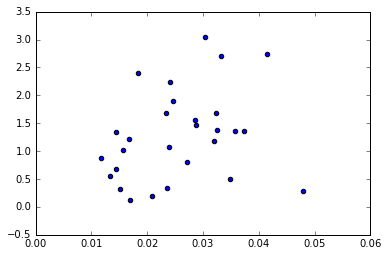

In [353]:
plt.scatter(maxs,appt)

### using raw Dij values instead of absolute values

In [354]:
#do pairwise pops for empirical SNPs IDed by OutFLANK and calculate median Dij for each pop pair
rawshiftDict = OrderedDict() 
kcount = 0
for m,popm in enumerate(impMAF.columns):
    print popm
    rawshiftDict[popm] = OrderedDict()
    for l,popl in enumerate(impMAF.columns):
        if m>l:
            dijlist = []
            for i,locusi in enumerate(outliersnps):
                for j,locusj in enumerate(outliersnps):
                    if i > j: #i=row, j=col : lower triangle 
                        sums =0
                        kcount += 1
                        for popk in [popm,popl]:
                            qik = impMAF.loc[locusi,popk] #get locusi maf for pop k
                            qjk = impMAF.loc[locusj,popk] #get locusj maf for pop k
                            nk = popDict[popk]            #N individuals in pop k
                            
                            globN = 2*(popDict[popm]+popDict[popl]) # number of alleles across 2 pops
                            
                            #get global mafs
                            fqim = impMAF.loc[locusi,popm]        #minor allele locusi freq  in popm
                            nqim = round(fqim*2*popDict[popm])    #minor allele locusi count in popm
                            fqil = impMAF.loc[locusi,popl]        #minor allele locusi freq  in popl
                            nqil = round(fqil*2*popDict[popl])    #minor allele locusi count in popl
                            
                            fqjm = impMAF.loc[locusj,popm]        #minor allele locusj freq  in popm
                            nqjm = round(fqjm*2*popDict[popm])    #minor allele locusj count in popm
                            fqjl = impMAF.loc[locusj,popl]        #minor allele locusj freq  in popl
                            nqjl = round(fqjl*2*popDict[popl])    #minor allele locusj count in popl
                            
                            qi = (nqim+nqil)/((2*popDict[popm])+(2*popDict[popl])) #global maf locusi
                            qj = (nqjm+nqjl)/((2*popDict[popm])+(2*popDict[popl])) #global maf locusj

                            sums += (nk/(popDict[popm]+popDict[popl]))*((qik*qjk)-(qi*qj))

                        dijlist.append(sums) #each pairwise pop comparison has a matrix of Dij
                    else:
                        pass #no redundancies, no diagonal. will be faster to reflect across diagonal later on
            rawshiftDict[popm][popl] = np.median([d for d in dijlist])
        else:
            rawshiftDict[popm][popl] = np.nan #no redundancies,no diagonal. will be faster to reflect across diag later
#    if kcount > 1:
#        break

Dicks_Pass
Freel_Peak
Heavenly
Little_Round_Top
Mt_Rose_Ophir
Rifle_Peak
Snow_Valley_Peak
West_Shore_Peaks


In [356]:
#write to file
filE = '/home/lindb/wbp/OutFLANK/freqshifts/pop_pairwise_raw_median_dij.text'
with open(filE,'w') as o:
    key0 = rawshiftDict.keys()[0]
    line = '\t'.join(rawshiftDict[key0].keys()) + str('\n')
    o.write("%s" % line)
    for popk in rawshiftDict.keys():
        text = str(popk)+'\t'+'\t'.join([str(d) for d in rawshiftDict[popk].values()])+'\n'
        o.write("%s" % text)

In [357]:
filE = '/home/lindb/wbp/OutFLANK/freqshifts/pop_pairwise_raw_median_dij.text'
rawshiftDF = pd.read_csv(filE,header=0,index_col=0,sep='\t')
for i,popi in enumerate(rawshiftDF.index):
    for j,popj in enumerate(rawshiftDF.columns):
        if i == j:
            rawshiftDF.loc[popi,popj] = 0
        elif math.isnan(rawshiftDF.loc[popi,popj]) == True:
            rawshiftDF.loc[popi,popj] = rawshiftDF.loc[popj,popi]
rawshiftDF

,Dicks_Pass,Freel_Peak,Heavenly,Little_Round_Top,Mt_Rose_Ophir,Rifle_Peak,Snow_Valley_Peak,West_Shore_Peaks
Dicks_Pass,0.000000e+00,0.000784,0.000200,6.938894e-18,0.000835,0.000731,4.763640e-03,5.997501e-04
Freel_Peak,7.838400e-04,0.000000,0.000009,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00
Heavenly,2.000000e-04,0.000009,0.000000,0.000000e+00,0.000043,0.000000,1.474386e-03,0.000000e+00
Little_Round_Top,6.938894e-18,0.000000,0.000000,0.000000e+00,0.000000,0.000000,4.737609e-04,0.000000e+00
Mt_Rose_Ophir,8.348116e-04,0.000000,0.000043,0.000000e+00,0.000000,0.000000,4.595571e-05,0.000000e+00
Rifle_Peak,7.309454e-04,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00
Snow_Valley_Peak,4.763640e-03,0.000000,0.001474,4.737609e-04,0.000046,0.000000,0.000000e+00,3.820555e-14
West_Shore_Peaks,5.997501e-04,0.000000,0.000000,0.000000e+00,0.000000,0.000000,3.820555e-14,0.000000e+00


In [358]:
for env in envdDict.keys():
    print env,skbio.stats.distance.mantel(rawshiftDF,envdDict[env],permutations=9999)

AWS0-25 (0.2588599535229304, 0.23980000000000001, 8)
AWS0-50 (0.2641217034419916, 0.23469999999999999, 8)
Ann-ppt (0.30954083777361852, 0.15190000000000001, 8)
CEC (-0.22639441077773764, 0.28439999999999999, 8)
Clay (-0.26307196899398844, 0.2792, 8)
Elev (0.009271726059366504, 0.96220000000000006, 8)
GDD-Aug (-0.27956628267263894, 0.17599999999999999, 8)
GDD-May (-0.13373579049080664, 0.74960000000000004, 8)
Lat (-0.0017490599876568197, 0.99560000000000004, 8)
Lon (0.29082587665334642, 0.1217, 8)
Max-rad-input (0.061207044228018197, 0.7873, 8)
Rock-cov (-0.28530581546539024, 0.18820000000000001, 8)
Sand (0.015311367094609346, 0.94699999999999995, 8)
Silt (0.17779783648207903, 0.45029999999999998, 8)
Tmax-July (0.33466992761767517, 0.047300000000000002, 8)
Tmin-Jan (0.062439791359677213, 0.79730000000000001, 8)
WC15Bar (0.25681728740527349, 0.25829999999999997, 8)
WC3rdbar (0.18714035824274602, 0.4506, 8)


In [ ]:
#below scripts aren't used

# visualizing allele frequency shifts

In [213]:
maxx = -1000
for col in shiftDF.columns:
    lst = [x for x in mirshiftDF[col].tolist() if math.isnan(x)==False]
    if len(lst) >0:
        m = max(lst)
        if m > maxx:
            maxx = m
maxx

0.039600000000000003

In [161]:
#same geographic arrangement around lake tahoe
pops = ['Heavenly',
        'Freel_Peak',
        'Little_Round_Top',
        'Dicks_Pass',
        'West_Shore_Peaks',
        'Rifle_Peak',
        'Mt_Rose_Ophir',
        'Snow_Valley_Peak']

In [162]:
lst = []
comps = []
for i,popi in enumerate(pops):
    for j,popj in enumerate(pops):
        if i > j:
            lst.append((i,j))
            comps.append((popi,popj))
lst

[(1, 0),
 (2, 0),
 (2, 1),
 (3, 0),
 (3, 1),
 (3, 2),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (5, 0),
 (5, 1),
 (5, 2),
 (5, 3),
 (5, 4),
 (6, 0),
 (6, 1),
 (6, 2),
 (6, 3),
 (6, 4),
 (6, 5),
 (7, 0),
 (7, 1),
 (7, 2),
 (7, 3),
 (7, 4),
 (7, 5),
 (7, 6)]

In [163]:
comps

[('Freel_Peak', 'Heavenly'),
 ('Little_Round_Top', 'Heavenly'),
 ('Little_Round_Top', 'Freel_Peak'),
 ('Dicks_Pass', 'Heavenly'),
 ('Dicks_Pass', 'Freel_Peak'),
 ('Dicks_Pass', 'Little_Round_Top'),
 ('West_Shore_Peaks', 'Heavenly'),
 ('West_Shore_Peaks', 'Freel_Peak'),
 ('West_Shore_Peaks', 'Little_Round_Top'),
 ('West_Shore_Peaks', 'Dicks_Pass'),
 ('Rifle_Peak', 'Heavenly'),
 ('Rifle_Peak', 'Freel_Peak'),
 ('Rifle_Peak', 'Little_Round_Top'),
 ('Rifle_Peak', 'Dicks_Pass'),
 ('Rifle_Peak', 'West_Shore_Peaks'),
 ('Mt_Rose_Ophir', 'Heavenly'),
 ('Mt_Rose_Ophir', 'Freel_Peak'),
 ('Mt_Rose_Ophir', 'Little_Round_Top'),
 ('Mt_Rose_Ophir', 'Dicks_Pass'),
 ('Mt_Rose_Ophir', 'West_Shore_Peaks'),
 ('Mt_Rose_Ophir', 'Rifle_Peak'),
 ('Snow_Valley_Peak', 'Heavenly'),
 ('Snow_Valley_Peak', 'Freel_Peak'),
 ('Snow_Valley_Peak', 'Little_Round_Top'),
 ('Snow_Valley_Peak', 'Dicks_Pass'),
 ('Snow_Valley_Peak', 'West_Shore_Peaks'),
 ('Snow_Valley_Peak', 'Rifle_Peak'),
 ('Snow_Valley_Peak', 'Mt_Rose_Ophir')]

In [164]:
g = Graph(lst)
g.vs["name"] = pops
g.vs["label"] = g.vs["name"]
layout = g.layout_circle()

In [165]:
comps[0]

('Freel_Peak', 'Heavenly')

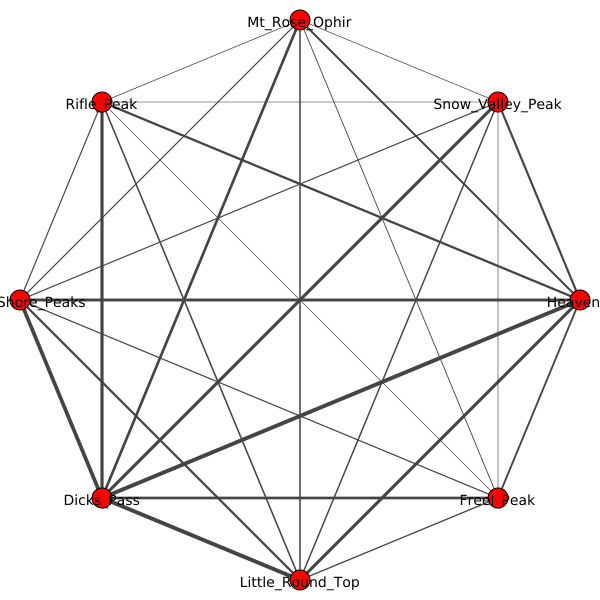

In [214]:
style = {}
#style["edge_width"] = [(4*(shiftDF.loc[comps[i][0],comps[i][1]]/maxx)) for i in range(len(comps))]
style["edge_width"] = [100*(mirshiftDF.loc[comps[i][0],comps[i][1]]) for i in range(len(comps))]
style["layout"] = layout
plot(g,**style)

In [81]:
shiftDict.keys()

['Dicks_Pass',
 'Freel_Peak',
 'Heavenly',
 'Little_Round_Top',
 'Mt_Rose_Ophir',
 'Rifle_Peak',
 'Snow_Valley_Peak',
 'West_Shore_Peaks']

In [85]:
shiftDF.index

Index([u'Dicks_Pass', u'Freel_Peak', u'Heavenly', u'Little_Round_Top',
       u'Mt_Rose_Ophir', u'Rifle_Peak', u'Snow_Valley_Peak',
       u'West_Shore_Peaks'],
      dtype='object')

In [102]:
graph = {
    'nodes': {
        'Dicks_Pass': {},
        'Freel_Peak': {},
        'Heavenly': {},
        'Little_Round_Top': {},
        'Mt_Rose_Ophir': {},
        'Rifle_Peak': {},
        'Snow_Valley_Peak': {},
        'West_Shore_Peaks': {},
    },
    'edges': [
        {'source': 'Dicks_Pass', 'target': 'Freel_Peak', 'size': shiftDF.loc['Freel_Peak','Dicks_Pass']/maxx},
        {'source': 'Dicks_Pass', 'target': 'Heavenly', 'size': shiftDF.loc['Heavenly','Dicks_Pass']/maxx},
        {'source': 'Dicks_Pass', 'target': 'Little_Round_Top', 'size': shiftDF.loc['Little_Round_Top','Dicks_Pass']/maxx},
        {'source': 'Dicks_Pass', 'target': 'Mt_Rose_Ophir', 'size': shiftDF.loc['Little_Round_Top','Dicks_Pass']/maxx},
        {'source': 'Dicks_Pass', 'target': 'Rifle_Peak', 'size': shiftDF.loc['Rifle_Peak','Dicks_Pass']/maxx},
        {'source': 'Dicks_Pass', 'target': 'Snow_Valley_Peak', 'size': shiftDF.loc['Snow_Valley_Peak','Dicks_Pass']/maxx},
        {'source': 'Dicks_Pass', 'target': 'West_Shore_Peaks', 'size': shiftDF.loc['West_Shore_Peaks','Dicks_Pass']/maxx},
        {'source': 'Freel_Peak', 'target': 'Heavenly', 'size': shiftDF.loc['Heavenly','Freel_Peak']/maxx},
        {'source': 'Freel_Peak', 'target': 'Little_Round_Top', 'size': shiftDF.loc['Little_Round_Top','Freel_Peak']/maxx},
        {'source': 'Freel_Peak', 'target': 'Mt_Rose_Ophir', 'size': shiftDF.loc['Mt_Rose_Ophir','Freel_Peak']/maxx},
        {'source': 'Freel_Peak', 'target': 'Rifle_Peak', 'size': shiftDF.loc['Rifle_Peak','Freel_Peak']/maxx},
        {'source': 'Freel_Peak', 'target': 'Snow_Valley_Peak', 'size': shiftDF.loc['Snow_Valley_Peak','Freel_Peak']/maxx},
        {'source': 'Freel_Peak', 'target': 'West_Shore_Peaks', 'size': shiftDF.loc['West_Shore_Peaks','Freel_Peak']/maxx},
        {'source': 'Heavenly', 'target': 'Little_Round_Top', 'size': shiftDF.loc['Little_Round_Top','Heavenly']/maxx},
        {'source': 'Heavenly', 'target': 'Mt_Rose_Ophir', 'size': shiftDF.loc['Mt_Rose_Ophir','Heavenly']/maxx},
        {'source': 'Heavenly', 'target': 'Rifle_Peak', 'size': shiftDF.loc['Rifle_Peak','Heavenly']/maxx},
        {'source': 'Heavenly', 'target': 'Snow_Valley_Peak', 'size': shiftDF.loc['Snow_Valley_Peak','Heavenly']/maxx},
        {'source': 'Heavenly', 'target': 'West_Shore_Peaks', 'size': shiftDF.loc['West_Shore_Peaks','Heavenly']/maxx},
        {'source': 'Little_Round_Top', 'target': 'Mt_Rose_Ophir', 'size': shiftDF.loc['Mt_Rose_Ophir','Little_Round_Top']/maxx},
        {'source': 'Little_Round_Top', 'target': 'Rifle_Peak', 'size': shiftDF.loc['Rifle_Peak','Little_Round_Top']/maxx},
        {'source': 'Little_Round_Top', 'target': 'Snow_Valley_Peak', 'size': shiftDF.loc['Snow_Valley_Peak','Little_Round_Top']/maxx},
        {'source': 'Little_Round_Top', 'target': 'West_Shore_Peaks', 'size': shiftDF.loc['West_Shore_Peaks','Little_Round_Top']/maxx},
        {'source': 'Mt_Rose_Ophir', 'target': 'Rifle_Peak', 'size': shiftDF.loc['Rifle_Peak','Mt_Rose_Ophir']/maxx},
        {'source': 'Mt_Rose_Ophir', 'target': 'Snow_Valley_Peak', 'size': shiftDF.loc['Snow_Valley_Peak','Mt_Rose_Ophir']/maxx},
        {'source': 'Mt_Rose_Ophir', 'target': 'West_Shore_Peaks', 'size': shiftDF.loc['West_Shore_Peaks','Mt_Rose_Ophir']/maxx},
        {'source': 'Rifle_Peak', 'target': 'Snow_Valley_Peak', 'size': shiftDF.loc['Snow_Valley_Peak','Rifle_Peak']/maxx},
        {'source': 'Rifle_Peak', 'target': 'West_Shore_Peaks', 'size': shiftDF.loc['West_Shore_Peaks','Rifle_Peak']/maxx},
        {'source': 'Snow_Valley_Peak', 'target': 'West_Shore_Peaks', 'size': shiftDF.loc['West_Shore_Peaks','Snow_Valley_Peak']/maxx},
        
    ]
}

jgraph.draw(graph)

In [100]:
layout = graph.layout("circle")
plot(graph,layout=layout)

AttributeError: 'dict' object has no attribute 'layout'

In [101]:
?jgraph

# old way of calculating covariance using random snps

In [ ]:
#this section was done before using H_exp (above)
#the folders here were moved from /covariances to /covariances_unweighted_allele_freqs

In [131]:
#do pairwise to get D
dDict = OrderedDict()
icount = 0
for i,locusi in enumerate(outliersnps):
    dDict[locusi] = OrderedDict()
    for j,locusj in enumerate(outliersnps):
        if i > j: #i=row, j=col : lower triangle
            asums = 0
            bsums = 0
            csums = 0
            for pop in impMAF.columns:
                p_i = impMAF.loc[locusi,pop]
                p_j = impMAF.loc[locusj,pop]

                #calc "a"
                product = p_i*p_j
                asums = asums + product

                #calc "b"
                bsums = bsums + p_i

                #calc "c" 
                csums = csums + p_j

            a = asums/len(impMAF.columns)
            b = bsums/len(impMAF.columns)
            c = csums/len(impMAF.columns)

            d = a - (b*c)
            dDict[locusi][locusj] = d
        else:
            dDict[locusi][locusj] = np.nan
    icount += 1
    if icount % 10 == 0:
        print icount

10
20
30
40
50
60
70
80
90
100
110


In [132]:
#write out the file
rowcount = 0
filE = '/home/lindb/wbp/OutFLANK/covariances/dvals/imputed_dvals.txt'
if not os.path.exists(os.path.dirname(filE)):
    os.makedirs(os.path.dirname(filE))
with open(filE,'w') as o:
    key0 = dDict.keys()[0]
    line = '\t'.join(dDict[key0].keys()) + str('\n')
    o.write("%s" % line)
    for locusi in dDict.keys():
        line = str(locusi)+'\t'+'\t'.join([str(x) for x in dDict[locusi].values()]) + str('\n')
        o.write("%s" % line)

In [133]:
dvals = pd.read_csv(filE,header=0,index_col=0,sep="\t")
dvals.head()

,NODE_1001690_length_90_cov_2.000000_37,NODE_1012475_length_88_cov_1.022727_43,NODE_1025193_length_75_cov_1.093333_47,NODE_1030410_length_81_cov_1.259259_40,NODE_1038234_length_92_cov_1.000000_53,NODE_1063087_length_97_cov_1.639175_100,NODE_107570_length_80_cov_1.350000_43,NODE_1082793_length_76_cov_1.026316_38,NODE_1090835_length_51_cov_1.921569_62,NODE_1092275_length_98_cov_3.897959_107,...,NODE_861529_length_116_cov_1.318966_103,NODE_866842_length_48_cov_1.229167_34,NODE_880604_length_66_cov_1.363636_44,NODE_893311_length_93_cov_2.000000_109,NODE_897315_length_77_cov_1.337662_38,NODE_904862_length_47_cov_1.382979_41,NODE_923338_length_97_cov_3.154639_15,NODE_983665_length_98_cov_2.000000_96,NODE_987313_length_98_cov_4.653061_59,NODE_988447_length_96_cov_2.697917_32
NODE_1001690_length_90_cov_2.000000_37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NODE_1012475_length_88_cov_1.022727_43,0.004050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NODE_1025193_length_75_cov_1.093333_47,0.000404,0.004778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NODE_1030410_length_81_cov_1.259259_40,0.003925,0.016184,0.005641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NODE_1038234_length_92_cov_1.000000_53,0.004630,0.010943,0.003383,0.014627,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [134]:
len(loci)

116231

In [135]:
#get a list of snps not IDed as outliers
bucket = set(loci) - set(outliersnps)
len(bucket)

116121

In [139]:
#get a list of snps not IDed as outliers
filE = '/home/lindb/wbp/OutFLANK/covariances/drawbuckets/outflank_bucket.txt'
snpbucket = pd.DataFrame([x for x in bucket])
if not os.path.exists(os.path.dirname(filE)):
    os.makedirs(os.path.dirname(filE))
snpbucket.to_csv(filE,header=True,index=True,sep="\t")

In [151]:
snpbucket = [x for x in snpbucket[0].tolist()]

In [159]:
#make 1000 dataframes with a set of snps == 110 = len(outliersnps)
for i in range(20):                                  #make 20 .py files
    for j in range(50):                              #each .py file makes 50 matrices
        snps = random.sample(snpbucket,len(outliersnps))           #select random snps

        DIR = '/home/lindb/wbp/OutFLANK/covariances/randmatrices/randsnps'
        if not os.path.exists(DIR):
            os.makedirs(DIR)
        filE = os.path.join(DIR,"outflank_%s_%s_randsnps.txt" % (str(i).zfill(2),str(j).zfill(2)))
        df = pd.DataFrame(snps)
        df.to_csv(filE,header=False,index=False,sep="\t")

In [156]:
df = pd.read_csv(filE,header=None,sep="\t")
df.head()

,0
0,NODE_1973495_length_96_cov_1.031250_116
1,NODE_1098008_length_94_cov_1.000000_99
2,NODE_1816274_length_94_cov_1.031915_84
3,NODE_739340_length_93_cov_2.881721_19
4,NODE_1585603_length_97_cov_2.000000_17


In [157]:
filE

'/home/lindb/wbp/OutFLANK/covariances/randmatrices/outflank_19_49_randsnps.txt'

In [160]:
#make .py files
for i in range(20):
    for j in range(50):
        text = '''from __future__ import division
import sys, os, time
import pandas as pd
import numpy as np
import vcf
import random
from collections import OrderedDict
from operator import itemgetter
from collections import defaultdict
import math
import shutil

filE= '/home/lindb/wbp/OutFLANK/covariances/randmatrices/randsnps/outflank_%s_%s_randsnps.txt'
df = pd.read_csv(filE,header=None,sep="\\t")
snps = df[0].tolist()

newdf = pd.read_csv('/home/lindb/wbp/OutFLANK/imputed_MAF.txt',header=0,index_col=0,sep="\\t")

icount = 0
rDict = OrderedDict()
for i,locusi in enumerate(snps):
    rDict[locusi] = OrderedDict()
    for j,locusj in enumerate(snps):
        if i > j: #i=row, j=col : lower tri
            asums = 0
            bsums = 0
            csums = 0
            for pop in newdf.columns:
                p_i = newdf.loc[locusi,pop]
                p_j = newdf.loc[locusj,pop]
                
                #calc "a"
                product = p_i*p_j
                asums = asums + product
                
                #calc "b"
                bsums = bsums + p_i
                
                #calc "c"
                csums = csums + p_j
            
            a = asums/len(newdf.columns)
            b = bsums/len(newdf.columns)
            c = csums/len(newdf.columns)
            
            d = a - (b*c)
            rDict[locusi][locusj] = d
        else:
            rDict[locusi][locusj] = np.nan
    icount += 1
    if icount %% 10 == 0:
        print icount

filE = '/home/lindb/wbp/OutFLANK/covariances/randmatrices/0outfiles/outflank_%s_%s_imputedDVALS.txt'
DIR = os.path.dirname(filE)
if not os.path.exists(DIR):
    os.makedirs(DIR)
with open(filE,'w') as o:
    line = '\\t'.join(snps) + str('\\n')
    o.write("%%s" %% line)
    for locusi in rDict.keys():
        line = str(locusi) + '\\t' + '\\t'.join([str(x) for x in rDict[locusi].values()]) + str('\\n')
        o.write("%%s" %% line)
    
''' % (str(i).zfill(2),str(j).zfill(2), 
       str(i).zfill(2),str(j).zfill(2))
        
        filE = '/home/lindb/wbp/OutFLANK/covariances/randmatrices/0pyfiles/outflank_%s_%s_imputed.py' % (str(i).zfill(2),
                                                                                                         str(j).zfill(2))
        DIR = os.path.dirname(filE)
        if not os.path.exists(DIR):
            os.makedirs(DIR)
        with open(filE,'w') as o:
            o.write(text)
        o.close()

In [174]:
DIR = '/home/lindb/wbp/OutFLANK/covariances/randmatrices/0pyfiles/'
files = os.listdir(DIR)
files = [os.path.join(DIR,f) for f in files]
len(files)

1000

In [167]:
files[0]

'outflank_00_00_imputed.py'

In [177]:
#make <=198 sh files to include imputed py files too (my qsub limit is 200, I have 2 things going at the moment
fcount =0
shcount =0
tcount =0
newsh = True
for f in sorted(files):
    if newsh == True:
        text = '''#!/bin/bash
#$ -N run%s 
#$ -V
#$ -j y
#$ -cwd
''' % str(shcount).zfill(3)
    newtext = '''
cd %s
python %s
''' % (os.path.dirname(f),os.path.basename(f))
    text = text + newtext
    
    fcount += 1
    tcount += 1
    newsh = False
    if (fcount == 6) or (tcount == 1000):
        newsh = True
        fcount =0
        filE = '/home/lindb/wbp/OutFLANK/covariances/randmatrices/0runfiles/%s_run.sh' % str(shcount).zfill(3)
        DIR = os.path.dirname(filE)
        if not os.path.exists(DIR):
            os.makedirs(DIR)
        with open(filE,'w') as o:
            o.write(text)
        o.close()
        
        shcount += 1
    if '%max-rad-input_00_00_imputed.py' in f:
        print "shcount",shcount

In [176]:
os.path.dirname(f)

'/home/lindb/wbp/OutFLANK/covariances/randmatrices/0pyfiles'

In [178]:
#check one to make sure it worked
df = pd.read_csv('/home/lindb/wbp/OutFLANK/covariances/randmatrices/0outfiles/outflank_18_46_imputedDVALS.txt',header=0,
                index_col = 0, sep="\t")
df.head()

,NODE_336286_length_45_cov_1.666667_52,NODE_1957212_length_97_cov_1.000000_49,NODE_1571027_length_50_cov_2.040000_45,NODE_335241_length_95_cov_1.263158_95,NODE_880442_length_98_cov_2.091837_10,NODE_565875_length_81_cov_1.469136_90,NODE_1706578_length_90_cov_1.000000_86,NODE_1416161_length_90_cov_1.155556_103,NODE_1057474_length_98_cov_1.387755_125,NODE_810209_length_57_cov_1.298246_63,...,NODE_1031856_length_92_cov_3.967391_93,NODE_1858985_length_97_cov_3.597938_85,NODE_1765139_length_126_cov_2.095238_125,NODE_773369_length_46_cov_6.956522_54,NODE_691317_length_98_cov_1.602041_107,NODE_114676_length_92_cov_1.500000_32,NODE_1180737_length_80_cov_1.037500_52,NODE_944803_length_96_cov_1.000000_9,NODE_1347610_length_93_cov_1.000000_30,NODE_2007580_length_95_cov_1.000000_45
NODE_336286_length_45_cov_1.666667_52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NODE_1957212_length_97_cov_1.000000_49,-0.000219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NODE_1571027_length_50_cov_2.040000_45,-0.000134,-0.000958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NODE_335241_length_95_cov_1.263158_95,0.000329,-0.000446,-0.000061,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NODE_880442_length_98_cov_2.091837_10,0.000450,-0.000653,0.000630,0.000854,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# place observed median in distribution of medians made from random SNPs

In [290]:
DF.head()

,NODE_1001690_length_90_cov_2.000000_37,NODE_1012475_length_88_cov_1.022727_43,NODE_1025193_length_75_cov_1.093333_47,NODE_1030410_length_81_cov_1.259259_40,NODE_1038234_length_92_cov_1.000000_53,NODE_1063087_length_97_cov_1.639175_100,NODE_107570_length_80_cov_1.350000_43,NODE_1082793_length_76_cov_1.026316_38,NODE_1090835_length_51_cov_1.921569_62,NODE_1092275_length_98_cov_3.897959_107,...,NODE_861529_length_116_cov_1.318966_103,NODE_866842_length_48_cov_1.229167_34,NODE_880604_length_66_cov_1.363636_44,NODE_893311_length_93_cov_2.000000_109,NODE_897315_length_77_cov_1.337662_38,NODE_904862_length_47_cov_1.382979_41,NODE_923338_length_97_cov_3.154639_15,NODE_983665_length_98_cov_2.000000_96,NODE_987313_length_98_cov_4.653061_59,NODE_988447_length_96_cov_2.697917_32
NODE_1001690_length_90_cov_2.000000_37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NODE_1012475_length_88_cov_1.022727_43,0.004050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NODE_1025193_length_75_cov_1.093333_47,0.000404,0.004778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NODE_1030410_length_81_cov_1.259259_40,0.003925,0.016184,0.005641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NODE_1038234_length_92_cov_1.000000_53,0.004630,0.010943,0.003383,0.014627,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [280]:
# get observed dvals
DF = pd.read_csv('/home/lindb/wbp/OutFLANK/covariances/dvals/imputed_dvals.txt',header=0,index_col=0,sep="\t")
dvals = []
for i,row in enumerate(DF.index):
    for j,col in enumerate(DF.columns):
        if i > j:
            dvals.append(DF.loc[row,col])
            
DIR = '/home/lindb/wbp/OutFLANK/covariances/randmatrices/0outfiles'
files = os.listdir(DIR)
files = [f for f in files if f.startswith('outflank')]

pvals = []
fcount = 0
allvals = []
medvals = []
for f in files:
    df = pd.read_csv(os.path.join(DIR,f),header=0,index_col=0,sep="\t")
    rvals = [] #random dij values
    for lst in df.values.tolist():
        for x in lst:
            if math.isnan(x) == False:
                rvals.append(x)
                allvals.append(x)
    
    medvals.append(np.median([abs(x) for x in rvals]))
    pvals.append(ks_2samp(rvals,dvals)[1])
    fcount += 1
    if fcount % 10 == 0:
        print fcount

filE = '/home/lindb/wbp/OutFLANK/covariances/randmatrices/0OBSpvals/outflank_imputed_observedpvalues.txt'
pvals = pd.DataFrame(pvals)
pvals.to_csv(filE,header=None,index=False,sep="\t")

In [282]:
sorts = sorted([abs(x) for x in medvals])

In [283]:
len(sorts)*.95

950.0

In [284]:
sorts[950]

0.00036672468466600002

In [285]:
max(sorts)

0.00045208673406100001

In [ ]:
plt.hist(medvals)[2] # this is the 1000 median values

In [302]:
med = np.median(dvals)

In [311]:
n5th = sorts[950]

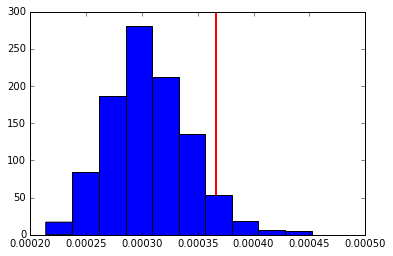

In [312]:
#this is the distribution of median values of random SNPs
#red line is the 95th percentile
plt.hist(sorts)[2] 
plt.axvline(x=n5th,c="red",linewidth=2,zorder=0) 

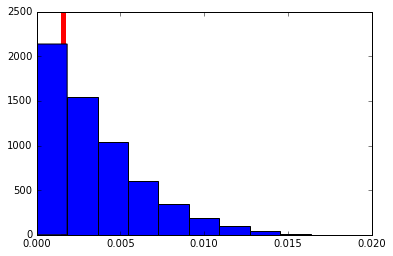

In [316]:
#this is the distribution of observed Dvals
#red line is the median value
fig = plt.hist([abs(x) for x in dvals])[2]
plt.axvline(x=med,c="red",linewidth=5,zorder=0)

In [287]:
np.median(dvals)

0.0015759621133599998

In [288]:
np.median(dvals) > max(sorts)

True

In [289]:
len(dvals)

5995

In [272]:
np.median(dvals)/max(sorts)

3.4859729220617992

In [277]:
len(dvals)

5995

In [295]:
#below what percentile of observed OBSdvals are the values less than the maximum randranddvals
for i,med in enumerate(sorted(dvals)):
    if not med < max(sorts):
        print i,i/len(dvals)
        break

2227 0.371476230192


In [297]:
sorts[950]

0.00036672468466600002

In [298]:
for i,med in enumerate(sorted(dvals)):
    if not med < sorts[950]:
        print i,i/len(dvals)
        break

2169 0.361801501251


In [188]:
len(loci),len(snpbucket)

(116231, 116121)

# ignore: effect distributions - effects pulled from 11_GEMMA.ipynb

In [375]:
from IPython.display import display

In [376]:
combined_dfs = {}
DIR = '/home/lindb/wbp/gemma/infiles/bslmm/output/'
for f in [op.join(DIR,f) for f in ls(DIR) if 'combined_df.txt' in f]:
    pheno = op.basename(f).split("_")[0]
    combined_dfs[pheno] = pd.read_csv(f,header=0,index_col=0,sep='\t')
    print pheno
    display(combined_dfs[pheno].head())

htpopx


,alpha_hmean,beta_hmean,gamma_hmean,total_effect
rs,,,,
NODE_803654_length_96_cov_2.916667_100,0.000140,0.094300,0.003535,0.094441
NODE_118775_length_91_cov_3.846154_42,0.000139,0.090890,0.002810,0.091029
NODE_1042213_length_96_cov_2.010417_23,0.000130,0.105395,0.003905,0.105525
NODE_1191856_length_56_cov_1.660714_52,0.000119,0.061644,0.002200,0.061763
NODE_715291_length_115_cov_1.626087_19,0.000119,0.085383,0.002480,0.085502


rspopx


,alpha_hmean,beta_hmean,gamma_hmean,total_effect
rs,,,,
NODE_1000013_length_91_cov_1.802198_37,0.000089,0.033259,0.001765,0.033348
NODE_1000031_length_98_cov_2.000000_30,0.000024,0.011842,0.001620,0.011866
NODE_1000037_length_93_cov_2.043011_33,0.000016,0.004484,0.001635,0.004500
NODE_1000042_length_93_cov_1.118280_100,0.000009,0.001231,0.001680,0.001240
NODE_1000053_length_94_cov_1.744681_25,0.000008,0.001378,0.001835,0.001386


c13popx


,alpha_hmean,beta_hmean,gamma_hmean,total_effect
rs,,,,
NODE_1000013_length_91_cov_1.802198_37,0.000006,0.008956,0.00137,0.008961
NODE_1000031_length_98_cov_2.000000_30,0.000003,0.000100,0.00166,0.000103
NODE_1000037_length_93_cov_2.043011_33,0.000021,0.004199,0.00142,0.004220
NODE_1000042_length_93_cov_1.118280_100,0.000008,0.002320,0.00150,0.002328
NODE_1000053_length_94_cov_1.744681_25,0.000041,0.027766,0.00163,0.027807


n15popx


,alpha_hmean,beta_hmean,gamma_hmean,total_effect
rs,,,,
NODE_1000013_length_91_cov_1.802198_37,0.000035,0.016382,0.001555,0.016417
NODE_1000031_length_98_cov_2.000000_30,0.000023,0.014235,0.001860,0.014257
NODE_1000037_length_93_cov_2.043011_33,0.000006,0.003460,0.001580,0.003465
NODE_1000042_length_93_cov_1.118280_100,0.000004,0.002745,0.001315,0.002749
NODE_1000053_length_94_cov_1.744681_25,0.000012,0.015700,0.001725,0.015713


bfpopx


,alpha_hmean,beta_hmean,gamma_hmean,total_effect
rs,,,,
NODE_1000013_length_91_cov_1.802198_37,0.000018,0.000751,0.00118,0.000770
NODE_1000031_length_98_cov_2.000000_30,0.000008,0.018813,0.00181,0.018821
NODE_1000037_length_93_cov_2.043011_33,0.000012,0.004933,0.00146,0.004945
NODE_1000042_length_93_cov_1.118280_100,0.000006,0.002573,0.00146,0.002579
NODE_1000053_length_94_cov_1.744681_25,0.000058,0.031942,0.00171,0.032000


In [415]:
#get a list of effects across phenotypes for each of the outlier snps
outfx = OrderedDict()
for snp in outliersnps:
    snp = str(snp)
    outfx[snp] = OrderedDict()
    outfx[snp]['alpha'] = []
    outfx[snp]['beta'] = []
    outfx[snp]['total'] = []
    outfx[snp]['gamma'] = []
    for pheno in combined_dfs:
        outfx[snp]['alpha'].append(combined_dfs[pheno].loc[snp,'alpha_hmean'])
        
        outfx[snp]['beta'].append(combined_dfs[pheno].loc[snp,'beta_hmean'])
        
        outfx[snp]['total'].append(combined_dfs[pheno].loc[snp,'total_effect'])
        
        outfx[snp]['gamma'].append(combined_dfs[pheno].loc[snp,'gamma_hmean'])

In [417]:
#get an average for each effect for each snp
for snp in outfx:
    outfx[snp]['mean alpha'] = np.mean([float(a) for a in outfx[snp]['alpha']])
    outfx[snp]['mean beta']  = np.mean([b for b in outfx[snp]['beta']])
    outfx[snp]['mean total'] = np.mean([t for t in outfx[snp]['total']])
    outfx[snp]['mean gamma'] = np.mean([g for g in outfx[snp]['gamma']])

In [427]:
outfx['NODE_1001690_length_90_cov_2.000000_37']

OrderedDict([('alpha',
              [4.6991895000000003e-06,
               1.5445775000000001e-06,
               3.0082017500000001e-06,
               3.0021499999999997e-06,
               1.41544075e-05]),
             ('beta',
              [0.0023814293499999999,
               0.0043603729999999999,
               0.016492326725000003,
               0.0060297355000000002,
               0.013418521250000001]),
             ('total',
              [0.0023861285394999997,
               0.0043619175775,
               0.016495334926799998,
               0.0060327376499999998,
               0.0134326756575]),
             ('gamma',
              [0.0015949999999999998,
               0.00183,
               0.0013699999999999999,
               0.0016249999999999999,
               0.00149]),
             ('mean alpha', 5.28170525e-06),
             ('mean beta', 0.0085364771650000004),
             ('mean total', 0.0085417588702599995),
             ('mean gamma', 0.001582000

In [431]:
#put the means into a list
outfx['total dist'] = []
outfx['gamma dist'] = []
outfx['alpha dist'] = []
outfx['beta dist'] = []
for snp in outfx:
    if ' ' not in snp:
        outfx['alpha dist'].append(outfx[snp]['mean alpha'])

        outfx['beta dist'].append(outfx[snp]['mean beta'])

        outfx['gamma dist'].append(outfx[snp]['mean gamma'])

        outfx['total dist'].append(outfx[snp]['mean total'])

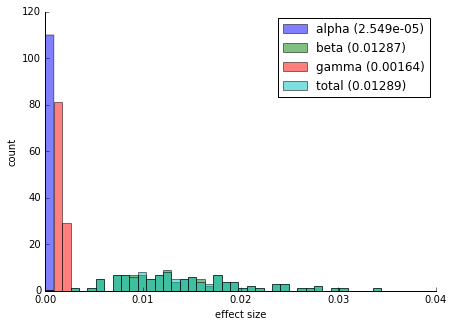

In [464]:
with PdfPages('/home/lindb/wbp/OutFLANK/figures/effects_4_criteria.pdf') as pdf:
#    crit = 'alpha_hmean'
    
#    plt.close('all')
#    fig , ((a1,a2,a3),(a4,a5,a6)) = plt.subplots(2, 3, figsize=(5,5),dpi=400)
    fig = plt.figure()
    ax = fig.add_subplot(111)
#    plotdict[count] = plt.subplot(int("23%s" % count))
    a = outfx['alpha dist']
    b = outfx['beta dist']
    c = outfx['gamma dist']
    d = outfx['total dist']
    bins=np.histogram(np.hstack((a,b,c,d)), bins=40)[1]
    ax.hist(a,label='alpha (%s)' % str(round(np.median(a),8)),alpha=0.5,bins=bins)
    ax.hist(b,label='beta (%s)' % str(round(np.median(b),5)),alpha=0.5,bins=bins)
    ax.hist(c,label='gamma (%s)' % str(round(np.median(c),5)),alpha=0.5,bins=bins)
    ax.hist(d,label='total (%s)' % str(round(np.median(d),5)),alpha=0.5,bins=bins)
    
#    plt.legend(['toppips','snpdict999','top alphas'])
    plt.legend()
#    plotdict[count].set_title('%s alpha' % pheno,y=.9,loc='left',fontsize=10,fontweight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel('effect size')
    ax.set_ylabel('count')
    ax.locator_params(axis='x',nbins=4)

    fig.set_size_inches(7,5)
    pdf.savefig(fig,bbox_inches='tight')


<a list of 40 Patch objects>

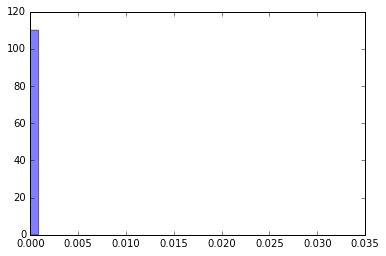

In [441]:
plt.hist(a,label='alpha dist',alpha=0.5,bins=bins)[2]

<a list of 40 Patch objects>

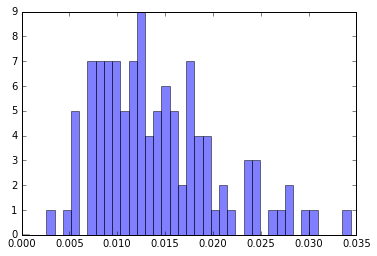

In [442]:
plt.hist(b,label='beta dist',alpha=0.5,bins=bins)[2]

<a list of 40 Patch objects>

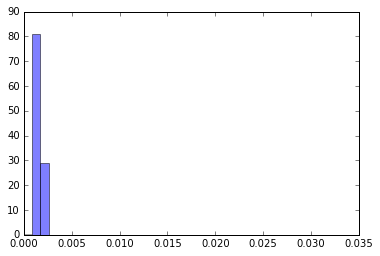

In [443]:
plt.hist(c,label='gamma dist',alpha=0.5,bins=bins)[2]

<a list of 40 Patch objects>

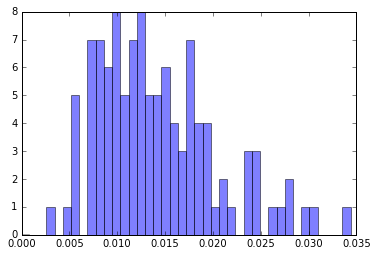

In [446]:
plt.hist(d,label='total dist',alpha=0.5,bins=bins)[2]

In [479]:
nonoutlier = {}
for pheno in combined_dfs:
    loci = combined_dfs[pheno].index.tolist()
    nonoutlier[pheno] = set(loci)-set(outliersnps)
    print len(nonoutlier[pheno]),len(loci),len(loci)-110

115492 115602 115492
115492 115602 115492
115476 115586 115476
115492 115602 115492
115487 115597 115487


In [484]:
len(H.index)

116231

In [489]:
nonoutliers = set(H.index.tolist()) - set(outliersnps)
len(nonoutliers)

116121

In [490]:
snpcount = 0
nonfx = OrderedDict()
for snp in nonoutliers:
    if not snp in nonfx.keys():
        nonfx[snp] = OrderedDict()
        nonfx[snp]['alpha'] = []
        nonfx[snp]['beta']  = []
        nonfx[snp]['total'] = []
        nonfx[snp]['gamma'] = []

    [nonfx[snp]['alpha'].append(combined_dfs[pheno].loc[snp,'alpha_hmean']) for pheno in combined_dfs if snp in combined_dfs[pheno].index]

    [nonfx[snp]['beta'].append(combined_dfs[pheno].loc[snp,'beta_hmean']) for pheno in combined_dfs if snp in combined_dfs[pheno].index]

    [nonfx[snp]['total'].append(combined_dfs[pheno].loc[snp,'total_effect']) for pheno in combined_dfs if snp in combined_dfs[pheno].index]

    [nonfx[snp]['gamma'].append(combined_dfs[pheno].loc[snp,'gamma_hmean']) for pheno in combined_dfs if snp in combined_dfs[pheno].index]
    
    snpcount += 1
    if snpcount % 1000 == 0:
        print snpcount

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000


In [491]:
#write out the file since it took so GD long to make
import pickle
with open('/home/lindb/wbp/OutFLANK/nonoutlier_effects.pkl',"wb") as o:
    pickle.dump(nonfx, o, pickle.HIGHEST_PROTOCOL)

In [492]:
#get an average for each effect for each snp
for snp in nonfx:
    nonfx[snp]['mean alpha'] = np.mean([float(a) for a in nonfx[snp]['alpha']])
    nonfx[snp]['mean beta']  = np.mean([b for b in nonfx[snp]['beta']])
    nonfx[snp]['mean total'] = np.mean([t for t in nonfx[snp]['total']])
    nonfx[snp]['mean gamma'] = np.mean([g for g in nonfx[snp]['gamma']])

/gpfs_fs/home/lindb/anaconda/envs/conda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [493]:
#put the means into a list
nonfx['total dist'] = []
nonfx['gamma dist'] = []
nonfx['alpha dist'] = []
nonfx['beta dist'] = []
for snp in nonfx:
    if ' ' not in snp:
        nonfx['alpha dist'].append(nonfx[snp]['mean alpha'])

        nonfx['beta dist'].append(nonfx[snp]['mean beta'])

        nonfx['gamma dist'].append(nonfx[snp]['mean gamma'])

        nonfx['total dist'].append(nonfx[snp]['mean total'])

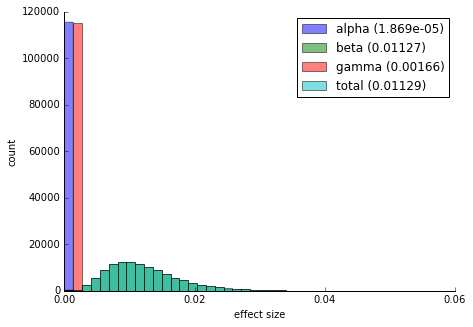

In [495]:
with PdfPages('/home/lindb/wbp/OutFLANK/figures/nonoutlier_effects_4_criteria.pdf') as pdf:
#    crit = 'alpha_hmean'
    
#    plt.close('all')
#    fig , ((a1,a2,a3),(a4,a5,a6)) = plt.subplots(2, 3, figsize=(5,5),dpi=400)
    fig = plt.figure()
    ax = fig.add_subplot(111)
#    plotdict[count] = plt.subplot(int("23%s" % count))
    a = [A for A in nonfx['alpha dist'] if math.isnan(A)==False]
    b = [B for B in nonfx['beta dist'] if math.isnan(B)==False]
    c = [C for C in nonfx['gamma dist'] if math.isnan(C)==False]
    d = [D for D in nonfx['total dist'] if math.isnan(D)==False]
    bins=np.histogram(np.hstack((a,b,c,d)), bins=40)[1]
    ax.hist(a,label='alpha (%s)' % str(round(np.median(a),8)),alpha=0.5,bins=bins)
    ax.hist(b,label='beta (%s)' % str(round(np.median(b),5)),alpha=0.5,bins=bins)
    ax.hist(c,label='gamma (%s)' % str(round(np.median(c),5)),alpha=0.5,bins=bins)
    ax.hist(d,label='total (%s)' % str(round(np.median(d),5)),alpha=0.5,bins=bins)
    
#    plt.legend(['toppips','snpdict999','top alphas'])
    plt.legend()
#    plotdict[count].set_title('%s alpha' % pheno,y=.9,loc='left',fontsize=10,fontweight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel('effect size')
    ax.set_ylabel('count')
    ax.locator_params(axis='x',nbins=4)

    fig.set_size_inches(7,5)
    pdf.savefig(fig,bbox_inches='tight')


In [497]:
max(b)

0.054245481499999991

In [498]:
from scipy.stats import wilcoxon

In [506]:
for crit in ['alpha dist','beta dist','gamma dist','total dist']:
    print crit
    o = [B for B in outfx[crit] if math.isnan(B)==False]
    n = [A for A in nonfx[crit] if math.isnan(A)==False]
    print "o=",np.median(o)
    print "n=",np.median(n)

alpha dist
o= 2.5490117675e-05
n= 1.8693900065e-05
beta dist
o= 0.012870257345
n= 0.01127220979
gamma dist
o= 0.0016415
n= 0.001662
total dist
o= 0.0128857854585
n= 0.0112916675203


In [501]:
len(o),len(n)

(110, 115495)

In [507]:
from scipy.stats.mstats import kruskalwallis

In [509]:
for crit in ['alpha dist','beta dist','gamma dist','total dist']:
    print crit
    o = [B for B in outfx[crit] if math.isnan(B)==False]
    n = [A for A in nonfx[crit] if math.isnan(A)==False]
    k = kruskalwallis(o,n)
    print crit,k
    print "max o",max(o)
    print "max n",max(n)

alpha dist
alpha dist KruskalResult(statistic=28.56003018224235, pvalue=9.083805250036183e-08)
max o 7.128271005e-05
max n 9.56341955e-05
beta dist
beta dist KruskalResult(statistic=11.204932138556746, pvalue=0.00081580209890184756)
max o 0.034322192225
max n 0.0542454815
gamma dist
gamma dist KruskalResult(statistic=4.1671833631657966, pvalue=0.041214261421066781)
max o 0.001917
max n 0.002756
total dist
total dist KruskalResult(statistic=11.237506560864858, pvalue=0.0008016077423364669)
max o 0.0343934749351
max n 0.054334171794


In [9]:
df = pd.read_csv('/home/lindb/wbp/OutFLANK/OutFlank_results2.txt',header=0,sep='\t')
df.head()

,LocusName,He,FST,T1,T2,FSTNoCorr,T1NoCorr,T2NoCorr,meanAlleleFreq,indexOrder,GoodH,qvalues,pvalues,pvaluesRightTail,OutlierFlag
0,NODE_1000013_length_91_cov_1.802198_37,0.212569,-0.007865,-0.000837,0.106477,0.015786,0.001682,0.106519,0.879098,1,goodH,0.852193,0.852652,0.573674,False
1,NODE_1000031_length_98_cov_2.000000_30,0.257290,0.012300,0.001589,0.129188,0.032527,0.004204,0.129231,0.848361,2,goodH,0.724113,0.236842,0.118421,False
2,NODE_1000037_length_93_cov_2.043011_33,0.215668,-0.009567,-0.001032,0.107910,0.006997,0.000755,0.107939,0.877049,3,goodH,0.882429,0.163997,0.918002,False
3,NODE_1000042_length_93_cov_1.118280_100,0.078608,0.000216,0.000009,0.039383,0.016198,0.000638,0.039393,0.959016,4,lowH,0.848006,0.886690,0.556655,False
4,NODE_1000053_length_94_cov_1.744681_25,0.047971,-0.005962,-0.000143,0.024014,0.010505,0.000252,0.024021,0.975410,5,lowH,0.872100,0.408936,0.795532,False


In [10]:
min(df['He'])

0.020281846277882199

In [14]:
df2 = pd.DataFrame(df[df['OutlierFlag'] == True])
len(df2.index)

110

In [16]:
df2['He'].describe()

count    110.000000
mean       0.305242
std        0.169550
min        0.020282
25%        0.137528
50%        0.358035
75%        0.466917
max        0.499160
Name: He, dtype: float64